In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

andrewmvd_lung_and_colon_cancer_histopathological_images_path = kagglehub.dataset_download('andrewmvd/lung-and-colon-cancer-histopathological-images')
farhinulfatanika_convnextkan_pytorch_default_1_path = kagglehub.model_download('farhinulfatanika/convnextkan/PyTorch/default/1')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca637.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca3400.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca783.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca3927.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca4109.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca95.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca488.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca2140.jp

In [ ]:
import os
from sklearn.model_selection import train_test_split
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [ ]:
# Kaggle paths
base_dir   = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set"
lung_dir   = os.path.join(base_dir, "lung_image_sets")
colon_dir  = os.path.join(base_dir, "colon_image_sets")


In [ ]:
# Map each class folder to an integer label
all_roots = [lung_dir, colon_dir]
class_to_idx = {}#map each folder to a num
samples = []#filepath,label

for root in all_roots:
    for class_name in sorted(os.listdir(root)):
        class_folder = os.path.join(root, class_name)
        if not os.path.isdir(class_folder):
            continue
        # assign label if not seen
        if class_name not in class_to_idx:
            class_to_idx[class_name] = len(class_to_idx)
        label = class_to_idx[class_name]
        # walk images
        for fname in os.listdir(class_folder):
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                samples.append((
                    os.path.join(class_folder, fname),
                    label
                ))

print(f"Found {len(samples)} images in {len(class_to_idx)} classes")
print("Class  label mapping:", class_to_idx)


Found 25000 images in 5 classes
Class  label mapping: {'lung_aca': 0, 'lung_n': 1, 'lung_scc': 2, 'colon_aca': 3, 'colon_n': 4}


In [ ]:
filepaths, labels = zip(*samples)

# 5% test set
fp_trainval, fp_test, lb_trainval, lb_test = train_test_split(
    filepaths, labels,
    test_size=0.05,
    stratify=labels,
    random_state=42
)

#  15% validation
val_ratio = 0.15 / 0.95

fp_train, fp_val, lb_train, lb_val = train_test_split(
    fp_trainval, lb_trainval,
    test_size=val_ratio,
    stratify=lb_trainval,
    random_state=42
)

print("Train:", len(fp_train))
print("Val:  ", len(fp_val))
print("Test: ", len(fp_test))


Train: 20000
Val:   3750
Test:  1250


In [ ]:
#split into patches

def split_into_patches(img, patch_size):#3xhxw
    _, h, w = img.shape
    patches = img.unfold(1, patch_size, patch_size)\
                 .unfold(2, patch_size, patch_size)
    return patches.contiguous()\
                  .view(-1, 3, patch_size, patch_size) #num of patches,3,patchsize,patchsize

class PatchDataset(torch.utils.data.Dataset):
    def __init__(self, filepaths, labels, transform, patch_size):
        self.filepaths = filepaths
        self.labels    = labels
        self.transform = transform
        self.patch_size = patch_size

    def __len__(self):
        return len(self.filepaths)#len of how many img

    def __getitem__(self, idx):#convert rgb--transform-resize,normalize
        img = Image.open(self.filepaths[idx]).convert("RGB")
        img = self.transform(img)
        patches = split_into_patches(img, self.patch_size)#to slice img
        return patches, self.labels[idx]


In [ ]:
patch_size  = 56
batch_size  = 32
num_workers = 2

train_tf = transforms.Compose([
    # transforms.RandomResizedCrop(224),#224x224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])
test_tf = transforms.Compose([
    # transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

train_ds = PatchDataset(fp_train, lb_train, train_tf, patch_size)
val_ds   = PatchDataset(fp_val,   lb_val,   test_tf,  patch_size)
test_ds  = PatchDataset(fp_test,  lb_test,  test_tf,  patch_size)

train_loader = DataLoader(train_ds,  batch_size=batch_size, shuffle=True,  num_workers=num_workers)
val_loader   = DataLoader(val_ds,    batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from tqdm import tqdm

class KANLinear(nn.Module):
    def __init__(
        self,
        in_features,#inputs
        out_features,
        grid_size=5,#tune #spline intervals
        spline_order=3,#degree
        scale_noise=0.1,#scale sp;ine noise
        scale_base=1.0,#scaling weight
        scale_spline=1.0,
        enable_standalone_scale_spline=True,#if we want to learn extra scaler per spline
        base_activation=nn.SiLU,#activation for base linear path
        grid_eps=0.02,
        grid_range=[-1, 1],#x range over which splines are defined
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        #knot positions from gridrange 0 to 1
        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        #register the grid as a buffer - non learnable state kept on the gpu
        self.register_buffer("grid", grid)
        #weights shape out,in
        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        #spline coeff one curve per out,in with grid size, spline order knots
        self.spline_weight = nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self): #weight i itialization
        #base linear weight
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        #initialize spline weights with small random noise then convert to b spline coeff
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            #if using standalone spline scaler init that
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x):#batch,in features
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid = self.grid #shape(in feature,gridsize+2*splineorder+1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        #recursively build higher order basis function
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        #final shape batch,in feature , gridsize+spline oder
        return bases.contiguous()
    #fitting curves to coeff
    def curve2coeff(self, x, y):

        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            #if enable multiply spline weights by its learned scaler per feature
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x):
        #flatten
        if x.dim() != 2 or x.size(1) != self.in_features:
            x = x.view(x.size(0), -1)  # Flatten the tensor

        assert x.dim() == 2 and x.size(1) == self.in_features
        #base linear path activation--linear
        base_output = F.linear(self.base_activation(x), self.base_weight)

        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)
        splines = splines.permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight
        orig_coeff = orig_coeff.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)
        unreduced_spline_output = unreduced_spline_output.permute(1, 0, 2)

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )

In [ ]:
class ConvNeXtKAN(nn.Module):
    def __init__(self, patch_size=56, num_classes=len(class_to_idx)):
        super().__init__()
        self.patch_size = patch_size

        self.convnext = models.convnext_tiny(pretrained=True)
        # reduce patch stride
        self.convnext.features[0][0].stride = (1,1)
        num_f = self.convnext.classifier[2].in_features
        self.convnext.classifier = nn.Identity()
        self.kan1 = KANLinear(num_f, 256)
        self.kan2 = KANLinear(256, num_classes)

    def forward(self, x):
        b, n, c, h, w = x.shape
        x = x.view(b*n, c, h, w)
        x = self.convnext(x)
        x = x.view(b, n, -1).mean(1)
        x = self.kan1(x)
        return self.kan2(x)

In [ ]:
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import amp

# DataParallel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = ConvNeXtKAN(patch_size, num_classes=len(class_to_idx)).to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

# Loss & optimize
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Mixed precision scaler
scaler = amp.GradScaler()

# -----------------------------------------------------------------------------
# Model summary
# -----------------------------------------------------------------------------
total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable    = total_params - trainable_params

print(f"Total parameters:         {total_params:,}")
print(f"Trainable parameters:     {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable:,}")
print(model)


Using 2 GPUs
Total parameters:         29,797,472
Trainable parameters:     29,797,472
Non-trainable parameters: 0
DataParallel(
  (module): ConvNeXtKAN(
    (convnext): ConvNeXt(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(1, 1))
          (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
        )
        (1): Sequential(
          (0): CNBlock(
            (block): Sequential(
              (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (1): Permute()
              (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (3): Linear(in_features=96, out_features=384, bias=True)
              (4): GELU(approximate='none')
              (5): Linear(in_features=384, out_features=96, bias=True)
              (6): Permute()
            )
            (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          )
          (1): CNBlock(
  

In [ ]:
import torch
import torch.nn as nn

# Unwrap DataParallel if used
base_model = model.module if isinstance(model, nn.DataParallel) else model

# 1) Total, trainable, non-trainable params
total_params     = sum(p.numel() for p in base_model.parameters())
trainable_params = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
non_trainable   = total_params - trainable_params

print(f"Total parameters:         {total_params:,}")
print(f"Trainable parameters:     {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable:,}")

# 2) Approximate size (float32 = 4 bytes)
size_mb = total_params * 4 / (1024 ** 2)
print(f"Approx. parameter size:   {size_mb:.2f} MB")

# 3) Example input shape
# Assuming your model expects (B, num_patches, 3, patch_size, patch_size)
patch_size    = base_model.patch_size
num_patches   = (224 // patch_size) ** 2
example_shape = (1, num_patches, 3, patch_size, patch_size)
print(f"Example input shape:      {example_shape}")

# 4) Detailed parameter breakdown
print("\nParameter breakdown (name: num_params, size_MB):")
for name, param in base_model.named_parameters():
    cnt = param.numel()
    mb  = cnt * 4 / (1024 ** 2)
    print(f"{name:50s}: {cnt:10,} params ({mb:.4f} MB)")

# 5) KANLinear-specific breakdown
print("\nKANLinear layers breakdown:")
# from kan import KANLinear
for mod_name, mod in base_model.named_modules():
    if isinstance(mod, KANLinear):
        bw     = mod.base_weight.numel()
        sw     = mod.spline_weight.numel()
        scaler = mod.spline_scaler.numel() if hasattr(mod, "spline_scaler") else 0
        print(f"{mod_name:30s}→ base_weight={bw:,}, spline_weight={sw:,}, spline_scaler={scaler:,}")

# 6) Full network architecture
print("\nNetwork architecture:")
print(base_model)


Total parameters:         29,797,472
Trainable parameters:     29,797,472
Non-trainable parameters: 0
Approx. parameter size:   113.67 MB
Example input shape:      (1, 16, 3, 56, 56)

Parameter breakdown (name: num_params, size_MB):
convnext.features.0.0.weight                      :      4,608 params (0.0176 MB)
convnext.features.0.0.bias                        :         96 params (0.0004 MB)
convnext.features.0.1.weight                      :         96 params (0.0004 MB)
convnext.features.0.1.bias                        :         96 params (0.0004 MB)
convnext.features.1.0.layer_scale                 :         96 params (0.0004 MB)
convnext.features.1.0.block.0.weight              :      4,704 params (0.0179 MB)
convnext.features.1.0.block.0.bias                :         96 params (0.0004 MB)
convnext.features.1.0.block.2.weight              :         96 params (0.0004 MB)
convnext.features.1.0.block.2.bias                :         96 params (0.0004 MB)
convnext.features.1.0.block.3

In [ ]:
# import threading
# import time

# def keep_alive():
#     while True:
#         print("Keeping session alive...", flush=True)
#         time.sleep(60)  # Ping every 60 seconds

# # Start the keep-alive thread
# t = threading.Thread(target=keep_alive)
# t.daemon = True  # Thread will automatically close when main process ends
# t.start()


Keeping session alive...


Epoch 1 ▶ Train:  10%|▉         | 61/625 [00:59<09:09,  1.03it/s]

Keeping session alive...


Epoch 1 ▶ Train:  19%|█▉        | 118/625 [01:58<09:16,  1.10s/it]

Keeping session alive...


Epoch 1 ▶ Train:  27%|██▋       | 169/625 [02:58<08:44,  1.15s/it]

Keeping session alive...


Epoch 1 ▶ Train:  36%|███▌      | 222/625 [03:59<07:45,  1.15s/it]

Keeping session alive...


Epoch 1 ▶ Train:  44%|████▍     | 275/625 [04:59<06:36,  1.13s/it]

Keeping session alive...


Epoch 1 ▶ Train:  52%|█████▏    | 328/625 [05:59<05:36,  1.13s/it]

Keeping session alive...


Epoch 1 ▶ Train:  61%|██████    | 380/625 [06:59<04:42,  1.15s/it]

Keeping session alive...


Epoch 1 ▶ Train:  69%|██████▉   | 433/625 [07:59<03:37,  1.14s/it]

Keeping session alive...


Epoch 1 ▶ Train:  78%|███████▊  | 485/625 [08:58<02:38,  1.13s/it]

Keeping session alive...


Epoch 1 ▶ Train:  86%|████████▌ | 538/625 [09:59<01:38,  1.13s/it]

Keeping session alive...


Epoch 1 ▶ Train:  95%|█████████▍| 591/625 [10:59<00:40,  1.19s/it]

Keeping session alive...


Epoch 1 ▶ Val:  45%|████▍     | 53/118 [00:21<00:26,  2.47it/s]

Keeping session alive...


Epoch 1 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.46it/s]


Epoch 1 Results → Train Loss: 0.9023, Acc: 0.5565 | Val Loss:   0.7780, Acc: 0.5835


Epoch 2 ▶ Train:   5%|▍         | 29/625 [00:33<11:18,  1.14s/it]

Keeping session alive...


Epoch 2 ▶ Train:  13%|█▎        | 81/625 [01:32<10:16,  1.13s/it]

Keeping session alive...


Epoch 2 ▶ Train:  21%|██▏       | 134/625 [02:32<09:15,  1.13s/it]

Keeping session alive...


Epoch 2 ▶ Train:  30%|██▉       | 187/625 [03:33<08:18,  1.14s/it]

Keeping session alive...


Epoch 2 ▶ Train:  38%|███▊      | 239/625 [04:32<07:18,  1.14s/it]

Keeping session alive...


Epoch 2 ▶ Train:  47%|████▋     | 292/625 [05:32<06:19,  1.14s/it]

Keeping session alive...


Epoch 2 ▶ Train:  55%|█████▌    | 345/625 [06:32<05:17,  1.13s/it]

Keeping session alive...


Epoch 2 ▶ Train:  64%|██████▎   | 398/625 [07:33<04:21,  1.15s/it]

Keeping session alive...


Epoch 2 ▶ Train:  72%|███████▏  | 450/625 [08:32<03:20,  1.14s/it]

Keeping session alive...


Epoch 2 ▶ Train:  80%|████████  | 502/625 [09:32<02:21,  1.15s/it]

Keeping session alive...


Epoch 2 ▶ Train:  89%|████████▉ | 555/625 [10:33<01:19,  1.14s/it]

Keeping session alive...


Epoch 2 ▶ Train:  97%|█████████▋| 608/625 [11:33<00:19,  1.14s/it]

Keeping session alive...


Epoch 2 ▶ Val:  84%|████████▍ | 99/118 [00:40<00:07,  2.47it/s]

Keeping session alive...


Epoch 2 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


Epoch 2 Results → Train Loss: 0.7466, Acc: 0.6436 | Val Loss:   0.5318, Acc: 0.7768


Epoch 3 ▶ Train:   7%|▋         | 45/625 [00:51<10:58,  1.14s/it]

Keeping session alive...


Epoch 3 ▶ Train:  16%|█▌        | 97/625 [01:51<10:08,  1.15s/it]

Keeping session alive...


Epoch 3 ▶ Train:  24%|██▍       | 149/625 [02:51<09:04,  1.14s/it]

Keeping session alive...


Epoch 3 ▶ Train:  32%|███▏      | 202/625 [03:52<08:00,  1.14s/it]

Keeping session alive...


Epoch 3 ▶ Train:  41%|████      | 254/625 [04:51<07:02,  1.14s/it]

Keeping session alive...


Epoch 3 ▶ Train:  49%|████▉     | 307/625 [05:52<06:02,  1.14s/it]

Keeping session alive...


Epoch 3 ▶ Train:  57%|█████▋    | 359/625 [06:51<05:02,  1.14s/it]

Keeping session alive...


Epoch 3 ▶ Train:  66%|██████▌   | 412/625 [07:51<04:02,  1.14s/it]

Keeping session alive...


Epoch 3 ▶ Train:  74%|███████▍  | 464/625 [08:51<03:04,  1.15s/it]

Keeping session alive...


Epoch 3 ▶ Train:  83%|████████▎ | 517/625 [09:51<02:03,  1.14s/it]

Keeping session alive...


Epoch 3 ▶ Train:  91%|█████████ | 569/625 [10:51<01:03,  1.14s/it]

Keeping session alive...


Epoch 3 ▶ Train: 100%|█████████▉| 622/625 [11:51<00:03,  1.14s/it]

Keeping session alive...


Epoch 3 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


Epoch 3 Results → Train Loss: 0.5821, Acc: 0.7482 | Val Loss:   0.5559, Acc: 0.7827


Epoch 4 ▶ Train:   1%|          | 7/625 [00:08<11:56,  1.16s/it]

Keeping session alive...


Epoch 4 ▶ Train:   9%|▉         | 59/625 [01:07<10:44,  1.14s/it]

Keeping session alive...


Epoch 4 ▶ Train:  18%|█▊        | 112/625 [02:08<09:46,  1.14s/it]

Keeping session alive...


Epoch 4 ▶ Train:  26%|██▌       | 164/625 [03:07<08:44,  1.14s/it]

Keeping session alive...


Epoch 4 ▶ Train:  35%|███▍      | 217/625 [04:08<07:46,  1.14s/it]

Keeping session alive...


Epoch 4 ▶ Train:  43%|████▎     | 270/625 [05:08<06:44,  1.14s/it]

Keeping session alive...


Epoch 4 ▶ Train:  52%|█████▏    | 322/625 [06:08<05:47,  1.15s/it]

Keeping session alive...


Epoch 4 ▶ Train:  60%|██████    | 375/625 [07:08<04:45,  1.14s/it]

Keeping session alive...


Epoch 4 ▶ Train:  68%|██████▊   | 427/625 [08:08<03:46,  1.14s/it]

Keeping session alive...


Epoch 4 ▶ Train:  77%|███████▋  | 479/625 [09:07<02:46,  1.14s/it]

Keeping session alive...


Epoch 4 ▶ Train:  85%|████████▌ | 532/625 [10:08<01:45,  1.13s/it]

Keeping session alive...


Epoch 4 ▶ Train:  94%|█████████▎| 585/625 [11:08<00:45,  1.13s/it]

Keeping session alive...


Epoch 4 ▶ Val:  29%|██▉       | 34/118 [00:14<00:34,  2.46it/s]

Keeping session alive...


Epoch 4 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


Epoch 4 Results → Train Loss: 0.4943, Acc: 0.7895 | Val Loss:   0.5519, Acc: 0.7920


Epoch 5 ▶ Train:   4%|▎         | 22/625 [00:25<11:25,  1.14s/it]

Keeping session alive...


Epoch 5 ▶ Train:  12%|█▏        | 74/625 [01:24<10:31,  1.15s/it]

Keeping session alive...


Epoch 5 ▶ Train:  20%|██        | 127/625 [02:25<09:27,  1.14s/it]

Keeping session alive...


Epoch 5 ▶ Train:  29%|██▊       | 179/625 [03:24<08:56,  1.20s/it]

Keeping session alive...


Epoch 5 ▶ Train:  37%|███▋      | 232/625 [04:25<07:29,  1.14s/it]

Keeping session alive...


Epoch 5 ▶ Train:  46%|████▌     | 285/625 [05:25<06:28,  1.14s/it]

Keeping session alive...


Epoch 5 ▶ Train:  54%|█████▍    | 337/625 [06:25<05:28,  1.14s/it]

Keeping session alive...


Epoch 5 ▶ Train:  62%|██████▏   | 390/625 [07:26<04:28,  1.14s/it]

Keeping session alive...


Epoch 5 ▶ Train:  71%|███████   | 442/625 [08:25<03:30,  1.15s/it]

Keeping session alive...


Epoch 5 ▶ Train:  79%|███████▉  | 494/625 [09:25<02:30,  1.15s/it]

Keeping session alive...


Epoch 5 ▶ Train:  87%|████████▋ | 546/625 [10:24<01:31,  1.15s/it]

Keeping session alive...


Epoch 5 ▶ Train:  96%|█████████▌| 599/625 [11:25<00:29,  1.14s/it]

Keeping session alive...


Epoch 5 ▶ Val:  62%|██████▏   | 73/118 [00:30<00:18,  2.48it/s]

Keeping session alive...


Epoch 5 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.44it/s]


Epoch 5 Results → Train Loss: 0.4217, Acc: 0.8222 | Val Loss:   0.3192, Acc: 0.8675


Epoch 6 ▶ Train:   6%|▌         | 35/625 [00:40<11:19,  1.15s/it]

Keeping session alive...


Epoch 6 ▶ Train:  14%|█▍        | 87/625 [01:40<10:18,  1.15s/it]

Keeping session alive...


Epoch 6 ▶ Train:  22%|██▏       | 140/625 [02:41<09:15,  1.14s/it]

Keeping session alive...


Epoch 6 ▶ Train:  31%|███       | 192/625 [03:41<08:15,  1.14s/it]

Keeping session alive...


Epoch 6 ▶ Train:  39%|███▉      | 244/625 [04:41<07:16,  1.15s/it]

Keeping session alive...


Epoch 6 ▶ Train:  47%|████▋     | 296/625 [05:41<06:13,  1.14s/it]

Keeping session alive...


Epoch 6 ▶ Train:  56%|█████▌    | 349/625 [06:41<05:17,  1.15s/it]

Keeping session alive...


Epoch 6 ▶ Train:  64%|██████▍   | 401/625 [07:41<04:14,  1.14s/it]

Keeping session alive...


Epoch 6 ▶ Train:  73%|███████▎  | 454/625 [08:41<03:16,  1.15s/it]

Keeping session alive...


Epoch 6 ▶ Train:  81%|████████  | 506/625 [09:41<02:15,  1.14s/it]

Keeping session alive...


Epoch 6 ▶ Train:  89%|████████▉ | 559/625 [10:41<01:15,  1.14s/it]

Keeping session alive...


Epoch 6 ▶ Train:  98%|█████████▊| 612/625 [11:41<00:14,  1.12s/it]

Keeping session alive...


Epoch 6 ▶ Val:  93%|█████████▎| 110/118 [00:45<00:03,  2.47it/s]

Keeping session alive...


Epoch 6 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


Epoch 6 Results → Train Loss: 0.3624, Acc: 0.8501 | Val Loss:   0.3477, Acc: 0.8653


Epoch 7 ▶ Train:   8%|▊         | 49/625 [00:56<11:03,  1.15s/it]

Keeping session alive...


Epoch 7 ▶ Train:  16%|█▋        | 102/625 [01:56<09:52,  1.13s/it]

Keeping session alive...


Epoch 7 ▶ Train:  25%|██▍       | 154/625 [02:55<08:52,  1.13s/it]

Keeping session alive...


Epoch 7 ▶ Train:  33%|███▎      | 207/625 [03:56<07:57,  1.14s/it]

Keeping session alive...


Epoch 7 ▶ Train:  41%|████▏     | 259/625 [04:55<06:56,  1.14s/it]

Keeping session alive...


Epoch 7 ▶ Train:  50%|████▉     | 312/625 [05:56<05:57,  1.14s/it]

Keeping session alive...


Epoch 7 ▶ Train:  58%|█████▊    | 365/625 [06:56<04:54,  1.13s/it]

Keeping session alive...


Epoch 7 ▶ Train:  67%|██████▋   | 418/625 [07:56<03:56,  1.14s/it]

Keeping session alive...


Epoch 7 ▶ Train:  75%|███████▌  | 470/625 [08:55<02:55,  1.14s/it]

Keeping session alive...


Epoch 7 ▶ Train:  84%|████████▎ | 523/625 [09:56<01:56,  1.14s/it]

Keeping session alive...


Epoch 7 ▶ Train:  92%|█████████▏| 575/625 [10:55<00:56,  1.14s/it]

Keeping session alive...


Epoch 7 ▶ Val:   7%|▋         | 8/118 [00:03<00:46,  2.39it/s]

Keeping session alive...


Epoch 7 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.44it/s]


Epoch 7 Results → Train Loss: 0.3382, Acc: 0.8627 | Val Loss:   0.3031, Acc: 0.8752


Epoch 8 ▶ Train:   2%|▏         | 13/625 [00:15<11:38,  1.14s/it]

Keeping session alive...


Epoch 8 ▶ Train:  10%|█         | 65/625 [01:14<10:37,  1.14s/it]

Keeping session alive...


Epoch 8 ▶ Train:  19%|█▉        | 118/625 [02:14<09:33,  1.13s/it]

Keeping session alive...


Epoch 8 ▶ Train:  27%|██▋       | 171/625 [03:14<08:37,  1.14s/it]

Keeping session alive...


Epoch 8 ▶ Train:  36%|███▌      | 223/625 [04:14<07:36,  1.14s/it]

Keeping session alive...


Epoch 8 ▶ Train:  44%|████▍     | 276/625 [05:14<06:39,  1.14s/it]

Keeping session alive...


Epoch 8 ▶ Train:  52%|█████▏    | 328/625 [06:14<05:37,  1.14s/it]

Keeping session alive...


Epoch 8 ▶ Train:  61%|██████    | 381/625 [07:14<04:35,  1.13s/it]

Keeping session alive...


Epoch 8 ▶ Train:  69%|██████▉   | 434/625 [08:14<03:36,  1.13s/it]

Keeping session alive...


Epoch 8 ▶ Train:  78%|███████▊  | 487/625 [09:14<02:36,  1.14s/it]

Keeping session alive...


Epoch 8 ▶ Train:  86%|████████▋ | 540/625 [10:15<01:36,  1.13s/it]

Keeping session alive...


Epoch 8 ▶ Train:  95%|█████████▍| 593/625 [11:15<00:36,  1.13s/it]

Keeping session alive...


Epoch 8 ▶ Val:  48%|████▊     | 57/118 [00:23<00:24,  2.47it/s]

Keeping session alive...


Epoch 8 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


Epoch 8 Results → Train Loss: 0.3030, Acc: 0.8710 | Val Loss:   0.2469, Acc: 0.8997


Epoch 9 ▶ Train:   5%|▍         | 30/625 [00:34<11:15,  1.13s/it]

Keeping session alive...


Epoch 9 ▶ Train:  13%|█▎        | 83/625 [01:34<10:14,  1.13s/it]

Keeping session alive...


Epoch 9 ▶ Train:  22%|██▏       | 136/625 [02:35<09:14,  1.13s/it]

Keeping session alive...


Epoch 9 ▶ Train:  30%|███       | 188/625 [03:34<08:19,  1.14s/it]

Keeping session alive...


Epoch 9 ▶ Train:  39%|███▊      | 241/625 [04:34<07:15,  1.13s/it]

Keeping session alive...


Epoch 9 ▶ Train:  47%|████▋     | 294/625 [05:34<06:13,  1.13s/it]

Keeping session alive...


Epoch 9 ▶ Train:  56%|█████▌    | 347/625 [06:34<05:16,  1.14s/it]

Keeping session alive...


Epoch 9 ▶ Train:  64%|██████▍   | 400/625 [07:35<04:16,  1.14s/it]

Keeping session alive...


Epoch 9 ▶ Train:  72%|███████▏  | 452/625 [08:34<03:15,  1.13s/it]

Keeping session alive...


Epoch 9 ▶ Train:  81%|████████  | 505/625 [09:34<02:16,  1.14s/it]

Keeping session alive...


Epoch 9 ▶ Train:  89%|████████▉ | 558/625 [10:34<01:16,  1.14s/it]

Keeping session alive...


Epoch 9 ▶ Train:  98%|█████████▊| 611/625 [11:34<00:15,  1.14s/it]

Keeping session alive...


Epoch 9 ▶ Val:  92%|█████████▏| 108/118 [00:44<00:04,  2.48it/s]

Keeping session alive...


Epoch 9 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.44it/s]


Epoch 9 Results → Train Loss: 0.2835, Acc: 0.8817 | Val Loss:   0.1933, Acc: 0.9240


Epoch 10 ▶ Train:   8%|▊         | 48/625 [00:54<10:55,  1.14s/it]

Keeping session alive...


Epoch 10 ▶ Train:  16%|█▌        | 101/625 [01:55<09:53,  1.13s/it]

Keeping session alive...


Epoch 10 ▶ Train:  25%|██▍       | 154/625 [02:55<08:54,  1.13s/it]

Keeping session alive...


Epoch 10 ▶ Train:  33%|███▎      | 206/625 [03:54<07:55,  1.14s/it]

Keeping session alive...


Epoch 10 ▶ Train:  41%|████▏     | 259/625 [04:55<06:54,  1.13s/it]

Keeping session alive...


Epoch 10 ▶ Train:  50%|████▉     | 312/625 [05:55<05:58,  1.14s/it]

Keeping session alive...


Epoch 10 ▶ Train:  58%|█████▊    | 364/625 [06:54<05:00,  1.15s/it]

Keeping session alive...


Epoch 10 ▶ Train:  67%|██████▋   | 417/625 [07:55<03:57,  1.14s/it]

Keeping session alive...


Epoch 10 ▶ Train:  75%|███████▌  | 470/625 [08:55<02:56,  1.14s/it]

Keeping session alive...


Epoch 10 ▶ Train:  84%|████████▎ | 522/625 [09:55<01:57,  1.14s/it]

Keeping session alive...


Epoch 10 ▶ Train:  92%|█████████▏| 575/625 [10:55<00:56,  1.14s/it]

Keeping session alive...


Epoch 10 ▶ Val:   6%|▌         | 7/118 [00:03<00:46,  2.39it/s]

Keeping session alive...


Epoch 10 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


Epoch 10 Results → Train Loss: 0.2596, Acc: 0.8921 | Val Loss:   0.1714, Acc: 0.9349


Epoch 11 ▶ Train:   2%|▏         | 12/625 [00:14<11:39,  1.14s/it]

Keeping session alive...


Epoch 11 ▶ Train:  10%|█         | 65/625 [01:14<10:42,  1.15s/it]

Keeping session alive...


Epoch 11 ▶ Train:  19%|█▊        | 117/625 [02:13<09:38,  1.14s/it]

Keeping session alive...


Epoch 11 ▶ Train:  27%|██▋       | 170/625 [03:13<08:35,  1.13s/it]

Keeping session alive...


Epoch 11 ▶ Train:  36%|███▌      | 223/625 [04:14<07:36,  1.14s/it]

Keeping session alive...


Epoch 11 ▶ Train:  44%|████▍     | 276/625 [05:14<06:35,  1.13s/it]

Keeping session alive...


Epoch 11 ▶ Train:  52%|█████▏    | 328/625 [06:13<05:38,  1.14s/it]

Keeping session alive...


Epoch 11 ▶ Train:  61%|██████    | 381/625 [07:14<04:37,  1.14s/it]

Keeping session alive...


Epoch 11 ▶ Train:  69%|██████▉   | 434/625 [08:14<03:36,  1.14s/it]

Keeping session alive...


Epoch 11 ▶ Train:  78%|███████▊  | 486/625 [09:13<02:39,  1.15s/it]

Keeping session alive...


Epoch 11 ▶ Train:  86%|████████▌ | 539/625 [10:13<01:37,  1.14s/it]

Keeping session alive...


Epoch 11 ▶ Train:  95%|█████████▍| 592/625 [11:13<00:37,  1.13s/it]

Keeping session alive...


Epoch 11 ▶ Val:  47%|████▋     | 55/118 [00:22<00:25,  2.47it/s]

Keeping session alive...


Epoch 11 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


Epoch 11 Results → Train Loss: 0.2458, Acc: 0.8972 | Val Loss:   0.1685, Acc: 0.9333


Epoch 12 ▶ Train:   5%|▍         | 30/625 [00:34<11:10,  1.13s/it]

Keeping session alive...


Epoch 12 ▶ Train:  13%|█▎        | 82/625 [01:33<10:19,  1.14s/it]

Keeping session alive...


Epoch 12 ▶ Train:  22%|██▏       | 135/625 [02:33<09:17,  1.14s/it]

Keeping session alive...


Epoch 12 ▶ Train:  30%|███       | 188/625 [03:34<08:19,  1.14s/it]

Keeping session alive...


Epoch 12 ▶ Train:  39%|███▊      | 241/625 [04:34<07:10,  1.12s/it]

Keeping session alive...


Epoch 12 ▶ Train:  47%|████▋     | 294/625 [05:34<06:11,  1.12s/it]

Keeping session alive...


Epoch 12 ▶ Train:  56%|█████▌    | 347/625 [06:34<05:15,  1.14s/it]

Keeping session alive...


Epoch 12 ▶ Train:  64%|██████▍   | 400/625 [07:34<04:13,  1.13s/it]

Keeping session alive...


Epoch 12 ▶ Train:  72%|███████▏  | 452/625 [08:33<03:17,  1.14s/it]

Keeping session alive...


Epoch 12 ▶ Train:  81%|████████  | 505/625 [09:33<02:16,  1.14s/it]

Keeping session alive...


Epoch 12 ▶ Train:  89%|████████▉ | 558/625 [10:33<01:16,  1.14s/it]

Keeping session alive...


Epoch 12 ▶ Train:  98%|█████████▊| 611/625 [11:34<00:15,  1.14s/it]

Keeping session alive...


Epoch 12 ▶ Val:  92%|█████████▏| 108/118 [00:44<00:04,  2.48it/s]

Keeping session alive...


Epoch 12 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


Epoch 12 Results → Train Loss: 0.2414, Acc: 0.8996 | Val Loss:   0.1565, Acc: 0.9347


Epoch 13 ▶ Train:   8%|▊         | 48/625 [00:54<10:55,  1.14s/it]

Keeping session alive...


Epoch 13 ▶ Train:  16%|█▌        | 101/625 [01:54<09:55,  1.14s/it]

Keeping session alive...


Epoch 13 ▶ Train:  25%|██▍       | 155/625 [02:55<08:55,  1.14s/it]

Keeping session alive...


Epoch 13 ▶ Train:  33%|███▎      | 208/625 [03:55<07:55,  1.14s/it]

Keeping session alive...


Epoch 13 ▶ Train:  42%|████▏     | 260/625 [04:54<06:56,  1.14s/it]

Keeping session alive...


Epoch 13 ▶ Train:  50%|█████     | 313/625 [05:54<05:52,  1.13s/it]

Keeping session alive...


Epoch 13 ▶ Train:  59%|█████▊    | 367/625 [06:55<04:51,  1.13s/it]

Keeping session alive...


Epoch 13 ▶ Train:  67%|██████▋   | 420/625 [07:55<03:52,  1.13s/it]

Keeping session alive...


Epoch 13 ▶ Train:  76%|███████▌  | 472/625 [08:54<02:53,  1.13s/it]

Keeping session alive...


Epoch 13 ▶ Train:  84%|████████▍ | 526/625 [09:55<01:51,  1.13s/it]

Keeping session alive...


Epoch 13 ▶ Train:  93%|█████████▎| 579/625 [10:55<00:52,  1.14s/it]

Keeping session alive...


Epoch 13 ▶ Val:  18%|█▊        | 21/118 [00:08<00:39,  2.48it/s]

Keeping session alive...


Epoch 13 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


Epoch 13 Results → Train Loss: 0.2542, Acc: 0.8965 | Val Loss:   0.1954, Acc: 0.9171


Epoch 14 ▶ Train:   3%|▎         | 17/625 [00:19<11:29,  1.13s/it]

Keeping session alive...


Epoch 14 ▶ Train:  11%|█         | 70/625 [01:20<10:31,  1.14s/it]

Keeping session alive...


Epoch 14 ▶ Train:  20%|█▉        | 123/625 [02:19<09:20,  1.12s/it]

Keeping session alive...


Epoch 14 ▶ Train:  28%|██▊       | 177/625 [03:20<08:22,  1.12s/it]

Keeping session alive...


Epoch 14 ▶ Train:  37%|███▋      | 230/625 [04:20<07:25,  1.13s/it]

Keeping session alive...


Epoch 14 ▶ Train:  45%|████▌     | 283/625 [05:20<06:28,  1.13s/it]

Keeping session alive...


Epoch 14 ▶ Train:  54%|█████▍    | 336/625 [06:20<05:25,  1.13s/it]

Keeping session alive...


Epoch 14 ▶ Train:  62%|██████▏   | 389/625 [07:20<04:25,  1.13s/it]

Keeping session alive...


Epoch 14 ▶ Train:  71%|███████   | 443/625 [08:20<03:22,  1.11s/it]

Keeping session alive...


Epoch 14 ▶ Train:  79%|███████▉  | 496/625 [09:20<02:24,  1.12s/it]

Keeping session alive...


Epoch 14 ▶ Train:  88%|████████▊ | 549/625 [10:19<01:25,  1.12s/it]

Keeping session alive...


Epoch 14 ▶ Train:  96%|█████████▋| 602/625 [11:19<00:25,  1.12s/it]

Keeping session alive...


Epoch 14 ▶ Val:  71%|███████   | 84/118 [00:34<00:13,  2.47it/s]

Keeping session alive...


Epoch 14 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


Epoch 14 Results → Train Loss: 0.2211, Acc: 0.9091 | Val Loss:   0.2062, Acc: 0.9128


Epoch 15 ▶ Train:   6%|▋         | 40/625 [00:45<11:00,  1.13s/it]

Keeping session alive...


Epoch 15 ▶ Train:  15%|█▍        | 93/625 [01:45<09:59,  1.13s/it]

Keeping session alive...


Epoch 15 ▶ Train:  24%|██▎       | 147/625 [02:45<08:53,  1.12s/it]

Keeping session alive...


Epoch 15 ▶ Train:  32%|███▏      | 201/625 [03:46<07:55,  1.12s/it]

Keeping session alive...


Epoch 15 ▶ Train:  41%|████      | 254/625 [04:46<06:59,  1.13s/it]

Keeping session alive...


Epoch 15 ▶ Train:  49%|████▉     | 307/625 [05:45<05:54,  1.12s/it]

Keeping session alive...


Epoch 15 ▶ Train:  58%|█████▊    | 361/625 [06:46<04:56,  1.12s/it]

Keeping session alive...


Epoch 15 ▶ Train:  66%|██████▌   | 414/625 [07:45<03:53,  1.11s/it]

Keeping session alive...


Epoch 15 ▶ Train:  75%|███████▍  | 468/625 [08:45<02:56,  1.12s/it]

Keeping session alive...


Epoch 15 ▶ Train:  84%|████████▎ | 522/625 [09:46<01:55,  1.12s/it]

Keeping session alive...


Epoch 15 ▶ Train:  92%|█████████▏| 575/625 [10:46<00:56,  1.13s/it]

Keeping session alive...


Epoch 15 ▶ Val:   7%|▋         | 8/118 [00:03<00:45,  2.41it/s]

Keeping session alive...


Epoch 15 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


Epoch 15 Results → Train Loss: 0.2200, Acc: 0.9083 | Val Loss:   0.1426, Acc: 0.9429


Epoch 16 ▶ Train:   2%|▏         | 13/625 [00:15<11:28,  1.13s/it]

Keeping session alive...


Epoch 16 ▶ Train:  11%|█         | 66/625 [01:14<10:29,  1.13s/it]

Keeping session alive...


Epoch 16 ▶ Train:  19%|█▉        | 119/625 [02:14<09:29,  1.13s/it]

Keeping session alive...


Epoch 16 ▶ Train:  28%|██▊       | 173/625 [03:15<08:27,  1.12s/it]

Keeping session alive...


Epoch 16 ▶ Train:  36%|███▌      | 226/625 [04:15<07:34,  1.14s/it]

Keeping session alive...


Epoch 16 ▶ Train:  44%|████▍     | 278/625 [05:14<06:34,  1.14s/it]

Keeping session alive...


Epoch 16 ▶ Train:  53%|█████▎    | 331/625 [06:14<05:29,  1.12s/it]

Keeping session alive...


Epoch 16 ▶ Train:  62%|██████▏   | 385/625 [07:15<04:29,  1.12s/it]

Keeping session alive...


Epoch 16 ▶ Train:  70%|███████   | 438/625 [08:14<03:29,  1.12s/it]

Keeping session alive...


Epoch 16 ▶ Train:  79%|███████▊  | 492/625 [09:15<02:30,  1.13s/it]

Keeping session alive...


Epoch 16 ▶ Train:  87%|████████▋ | 545/625 [10:15<01:30,  1.13s/it]

Keeping session alive...


Epoch 16 ▶ Train:  96%|█████████▌| 598/625 [11:15<00:30,  1.14s/it]

Keeping session alive...


Epoch 16 ▶ Val:  60%|██████    | 71/118 [00:29<00:19,  2.47it/s]

Keeping session alive...


Epoch 16 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


Epoch 16 Results → Train Loss: 0.2170, Acc: 0.9083 | Val Loss:   0.1469, Acc: 0.9472


Epoch 17 ▶ Train:   6%|▌         | 35/625 [00:40<11:10,  1.14s/it]

Keeping session alive...


Epoch 17 ▶ Train:  14%|█▍        | 88/625 [01:40<10:06,  1.13s/it]

Keeping session alive...


Epoch 17 ▶ Train:  23%|██▎       | 141/625 [02:40<09:01,  1.12s/it]

Keeping session alive...


Epoch 17 ▶ Train:  31%|███       | 194/625 [03:40<08:05,  1.13s/it]

Keeping session alive...


Epoch 17 ▶ Train:  40%|███▉      | 247/625 [04:39<07:07,  1.13s/it]

Keeping session alive...


Epoch 17 ▶ Train:  48%|████▊     | 300/625 [05:40<06:09,  1.14s/it]

Keeping session alive...


Epoch 17 ▶ Train:  56%|█████▋    | 353/625 [06:39<05:08,  1.13s/it]

Keeping session alive...


Epoch 17 ▶ Train:  65%|██████▍   | 406/625 [07:39<04:07,  1.13s/it]

Keeping session alive...


Epoch 17 ▶ Train:  74%|███████▎  | 460/625 [08:40<03:05,  1.13s/it]

Keeping session alive...


Epoch 17 ▶ Train:  82%|████████▏ | 513/625 [09:40<02:07,  1.14s/it]

Keeping session alive...


Epoch 17 ▶ Train:  91%|█████████ | 566/625 [10:39<01:06,  1.12s/it]

Keeping session alive...


Epoch 17 ▶ Train:  99%|█████████▉| 620/625 [11:40<00:05,  1.11s/it]

Keeping session alive...


Epoch 17 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


Epoch 17 Results → Train Loss: 0.2022, Acc: 0.9188 | Val Loss:   0.1677, Acc: 0.9331


Epoch 18 ▶ Train:   1%|          | 5/625 [00:06<11:59,  1.16s/it]

Keeping session alive...


Epoch 18 ▶ Train:   9%|▉         | 58/625 [01:05<10:35,  1.12s/it]

Keeping session alive...


Epoch 18 ▶ Train:  18%|█▊        | 112/625 [02:05<09:40,  1.13s/it]

Keeping session alive...


Epoch 18 ▶ Train:  26%|██▋       | 165/625 [03:05<08:40,  1.13s/it]

Keeping session alive...


Epoch 18 ▶ Train:  35%|███▍      | 218/625 [04:05<07:40,  1.13s/it]

Keeping session alive...


Epoch 18 ▶ Train:  44%|████▎     | 272/625 [05:06<06:33,  1.12s/it]

Keeping session alive...


Epoch 18 ▶ Train:  52%|█████▏    | 325/625 [06:05<05:38,  1.13s/it]

Keeping session alive...


Epoch 18 ▶ Train:  61%|██████    | 379/625 [07:06<04:34,  1.11s/it]

Keeping session alive...


Epoch 18 ▶ Train:  69%|██████▉   | 432/625 [08:05<03:37,  1.13s/it]

Keeping session alive...


Epoch 18 ▶ Train:  78%|███████▊  | 486/625 [09:06<02:36,  1.13s/it]

Keeping session alive...


Epoch 18 ▶ Train:  86%|████████▌ | 539/625 [10:05<01:36,  1.12s/it]

Keeping session alive...


Epoch 18 ▶ Train:  95%|█████████▍| 592/625 [11:05<00:37,  1.13s/it]

Keeping session alive...


Epoch 18 ▶ Val:  48%|████▊     | 57/118 [00:23<00:24,  2.47it/s]

Keeping session alive...


Epoch 18 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


Epoch 18 Results → Train Loss: 0.2009, Acc: 0.9194 | Val Loss:   0.1370, Acc: 0.9443


Epoch 19 ▶ Train:   5%|▍         | 31/625 [00:35<11:12,  1.13s/it]

Keeping session alive...


Epoch 19 ▶ Train:  13%|█▎        | 84/625 [01:34<10:03,  1.12s/it]

Keeping session alive...


Epoch 19 ▶ Train:  22%|██▏       | 137/625 [02:34<09:06,  1.12s/it]

Keeping session alive...


Epoch 19 ▶ Train:  31%|███       | 191/625 [03:35<08:02,  1.11s/it]

Keeping session alive...


Epoch 19 ▶ Train:  39%|███▉      | 244/625 [04:34<07:05,  1.12s/it]

Keeping session alive...


Epoch 19 ▶ Train:  48%|████▊     | 298/625 [05:34<06:06,  1.12s/it]

Keeping session alive...


Epoch 19 ▶ Train:  56%|█████▋    | 352/625 [06:35<05:04,  1.11s/it]

Keeping session alive...


Epoch 19 ▶ Train:  65%|██████▍   | 405/625 [07:34<04:06,  1.12s/it]

Keeping session alive...


Epoch 19 ▶ Train:  73%|███████▎  | 459/625 [08:35<03:05,  1.12s/it]

Keeping session alive...


Epoch 19 ▶ Train:  82%|████████▏ | 513/625 [09:35<02:05,  1.12s/it]

Keeping session alive...


Epoch 19 ▶ Train:  91%|█████████ | 566/625 [10:35<01:06,  1.13s/it]

Keeping session alive...


Epoch 19 ▶ Train:  99%|█████████▉| 619/625 [11:34<00:06,  1.13s/it]

Keeping session alive...


Epoch 19 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.46it/s]


Epoch 19 Results → Train Loss: 0.1921, Acc: 0.9212 | Val Loss:   0.1307, Acc: 0.9496


Epoch 20 ▶ Train:   1%|          | 4/625 [00:04<12:14,  1.18s/it]

Keeping session alive...


Epoch 20 ▶ Train:   9%|▉         | 57/625 [01:04<10:38,  1.12s/it]

Keeping session alive...


Epoch 20 ▶ Train:  18%|█▊        | 111/625 [02:05<09:39,  1.13s/it]

Keeping session alive...


Epoch 20 ▶ Train:  26%|██▌       | 164/625 [03:04<08:34,  1.12s/it]

Keeping session alive...


Epoch 20 ▶ Train:  35%|███▍      | 218/625 [04:04<07:30,  1.11s/it]

Keeping session alive...


Epoch 20 ▶ Train:  44%|████▎     | 272/625 [05:04<06:31,  1.11s/it]

Keeping session alive...


Epoch 20 ▶ Train:  52%|█████▏    | 325/625 [06:04<05:35,  1.12s/it]

Keeping session alive...


Epoch 20 ▶ Train:  61%|██████    | 379/625 [07:05<04:37,  1.13s/it]

Keeping session alive...


Epoch 20 ▶ Train:  69%|██████▉   | 432/625 [08:04<03:35,  1.12s/it]

Keeping session alive...


Epoch 20 ▶ Train:  78%|███████▊  | 486/625 [09:04<02:35,  1.12s/it]

Keeping session alive...


Epoch 20 ▶ Train:  86%|████████▋ | 540/625 [10:04<01:34,  1.11s/it]

Keeping session alive...


Epoch 20 ▶ Train:  95%|█████████▌| 594/625 [11:04<00:34,  1.11s/it]

Keeping session alive...


Epoch 20 ▶ Val:  53%|█████▎    | 62/118 [00:25<00:22,  2.49it/s]

Keeping session alive...


Epoch 20 ▶ Val: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]


Epoch 20 Results → Train Loss: 0.1832, Acc: 0.9258 | Val Loss:   0.1737, Acc: 0.9248


Epoch 21 ▶ Train:   5%|▌         | 33/625 [00:37<11:04,  1.12s/it]

Keeping session alive...


Epoch 21 ▶ Train:  14%|█▍        | 86/625 [01:36<10:06,  1.13s/it]

Keeping session alive...


Epoch 21 ▶ Train:  22%|██▏       | 140/625 [02:37<08:59,  1.11s/it]

Keeping session alive...


Epoch 21 ▶ Train:  31%|███       | 193/625 [03:36<07:59,  1.11s/it]

Keeping session alive...


Epoch 21 ▶ Train:  40%|███▉      | 247/625 [04:36<07:00,  1.11s/it]

Keeping session alive...


Epoch 21 ▶ Train:  48%|████▊     | 301/625 [05:36<06:04,  1.13s/it]

Keeping session alive...


Epoch 21 ▶ Train:  57%|█████▋    | 355/625 [06:37<05:05,  1.13s/it]

Keeping session alive...


Epoch 21 ▶ Train:  65%|██████▌   | 408/625 [07:36<04:02,  1.12s/it]

Keeping session alive...


Epoch 21 ▶ Train:  74%|███████▍  | 462/625 [08:36<03:00,  1.11s/it]

Keeping session alive...


Epoch 21 ▶ Train:  83%|████████▎ | 516/625 [09:36<02:00,  1.10s/it]

Keeping session alive...


Epoch 21 ▶ Train:  91%|█████████ | 570/625 [10:36<01:01,  1.11s/it]

Keeping session alive...


Epoch 21 ▶ Train: 100%|█████████▉| 624/625 [11:36<00:01,  1.11s/it]

Keeping session alive...


Epoch 21 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.47it/s]


Epoch 21 Results → Train Loss: 0.1932, Acc: 0.9222 | Val Loss:   0.1786, Acc: 0.9216


Epoch 22 ▶ Train:   1%|▏         | 9/625 [00:10<11:30,  1.12s/it]

Keeping session alive...


Epoch 22 ▶ Train:  10%|█         | 63/625 [01:10<10:25,  1.11s/it]

Keeping session alive...


Epoch 22 ▶ Train:  19%|█▊        | 117/625 [02:10<09:27,  1.12s/it]

Keeping session alive...


Epoch 22 ▶ Train:  27%|██▋       | 171/625 [03:10<08:25,  1.11s/it]

Keeping session alive...


Epoch 22 ▶ Train:  36%|███▌      | 225/625 [04:10<07:27,  1.12s/it]

Keeping session alive...


Epoch 22 ▶ Train:  45%|████▍     | 279/625 [05:11<06:27,  1.12s/it]

Keeping session alive...


Epoch 22 ▶ Train:  53%|█████▎    | 333/625 [06:10<05:25,  1.11s/it]

Keeping session alive...


Epoch 22 ▶ Train:  62%|██████▏   | 387/625 [07:10<04:24,  1.11s/it]

Keeping session alive...


Epoch 22 ▶ Train:  71%|███████   | 441/625 [08:10<03:23,  1.11s/it]

Keeping session alive...


Epoch 22 ▶ Train:  79%|███████▉  | 495/625 [09:11<02:25,  1.12s/it]

Keeping session alive...


Epoch 22 ▶ Train:  88%|████████▊ | 549/625 [10:11<01:24,  1.12s/it]

Keeping session alive...


Epoch 22 ▶ Train:  96%|█████████▋| 602/625 [11:10<00:25,  1.11s/it]

Keeping session alive...


Epoch 22 ▶ Val:  73%|███████▎  | 86/118 [00:35<00:12,  2.50it/s]

Keeping session alive...


Epoch 22 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.47it/s]


Epoch 22 Results → Train Loss: 0.1804, Acc: 0.9276 | Val Loss:   0.2177, Acc: 0.8981


Epoch 23 ▶ Train:   7%|▋         | 41/625 [00:46<10:50,  1.11s/it]

Keeping session alive...


Epoch 23 ▶ Train:  15%|█▌        | 95/625 [01:46<09:49,  1.11s/it]

Keeping session alive...


Epoch 23 ▶ Train:  24%|██▍       | 149/625 [02:46<08:49,  1.11s/it]

Keeping session alive...


Epoch 23 ▶ Train:  32%|███▏      | 203/625 [03:46<07:50,  1.11s/it]

Keeping session alive...


Epoch 23 ▶ Train:  41%|████      | 257/625 [04:46<06:53,  1.12s/it]

Keeping session alive...


Epoch 23 ▶ Train:  50%|████▉     | 311/625 [05:46<05:50,  1.12s/it]

Keeping session alive...


Epoch 23 ▶ Train:  58%|█████▊    | 365/625 [06:46<04:49,  1.11s/it]

Keeping session alive...


Epoch 23 ▶ Train:  67%|██████▋   | 419/625 [07:46<03:49,  1.11s/it]

Keeping session alive...


Epoch 23 ▶ Train:  76%|███████▌  | 473/625 [08:47<02:49,  1.12s/it]

Keeping session alive...


Epoch 23 ▶ Train:  84%|████████▍ | 527/625 [09:47<01:48,  1.11s/it]

Keeping session alive...


Epoch 23 ▶ Train:  93%|█████████▎| 581/625 [10:46<00:48,  1.10s/it]

Keeping session alive...


Epoch 23 ▶ Val:  23%|██▎       | 27/118 [00:11<00:39,  2.31it/s]

Keeping session alive...


Epoch 23 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.47it/s]


Epoch 23 Results → Train Loss: 0.1787, Acc: 0.9275 | Val Loss:   0.1045, Acc: 0.9592


Epoch 24 ▶ Train:   3%|▎         | 20/625 [00:22<11:10,  1.11s/it]

Keeping session alive...


Epoch 24 ▶ Train:  12%|█▏        | 74/625 [01:22<10:11,  1.11s/it]

Keeping session alive...


Epoch 24 ▶ Train:  20%|██        | 128/625 [02:23<09:13,  1.11s/it]

Keeping session alive...


Epoch 24 ▶ Train:  29%|██▉       | 181/625 [03:22<08:25,  1.14s/it]

Keeping session alive...


Epoch 24 ▶ Train:  38%|███▊      | 235/625 [04:22<07:17,  1.12s/it]

Keeping session alive...


Epoch 24 ▶ Train:  46%|████▌     | 289/625 [05:22<06:16,  1.12s/it]

Keeping session alive...


Epoch 24 ▶ Train:  55%|█████▍    | 343/625 [06:22<05:13,  1.11s/it]

Keeping session alive...


Epoch 24 ▶ Train:  64%|██████▎   | 397/625 [07:22<04:13,  1.11s/it]

Keeping session alive...


Epoch 24 ▶ Train:  72%|███████▏  | 451/625 [08:22<03:13,  1.11s/it]

Keeping session alive...


Epoch 24 ▶ Train:  81%|████████  | 505/625 [09:22<02:14,  1.12s/it]

Keeping session alive...


Epoch 24 ▶ Train:  89%|████████▉ | 559/625 [10:22<01:13,  1.11s/it]

Keeping session alive...


Epoch 24 ▶ Train:  98%|█████████▊| 613/625 [11:23<00:13,  1.11s/it]

Keeping session alive...


Epoch 24 ▶ Val:  97%|█████████▋| 115/118 [00:46<00:01,  2.50it/s]

Keeping session alive...


Epoch 24 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.47it/s]


Epoch 24 Results → Train Loss: 0.1734, Acc: 0.9286 | Val Loss:   0.1372, Acc: 0.9411


Epoch 25 ▶ Train:   8%|▊         | 52/625 [00:58<10:41,  1.12s/it]

Keeping session alive...


Epoch 25 ▶ Train:  17%|█▋        | 105/625 [01:57<09:42,  1.12s/it]

Keeping session alive...


Epoch 25 ▶ Train:  25%|██▌       | 159/625 [02:58<08:41,  1.12s/it]

Keeping session alive...


Epoch 25 ▶ Train:  34%|███▍      | 212/625 [03:57<07:40,  1.11s/it]

Keeping session alive...


Epoch 25 ▶ Train:  43%|████▎     | 266/625 [04:58<06:41,  1.12s/it]

Keeping session alive...


Epoch 25 ▶ Train:  51%|█████     | 320/625 [05:58<05:40,  1.12s/it]

Keeping session alive...


Epoch 25 ▶ Train:  60%|█████▉    | 374/625 [06:58<04:39,  1.12s/it]

Keeping session alive...


Epoch 25 ▶ Train:  68%|██████▊   | 427/625 [07:57<03:39,  1.11s/it]

Keeping session alive...


Epoch 25 ▶ Train:  77%|███████▋  | 481/625 [08:57<02:39,  1.11s/it]

Keeping session alive...


Epoch 25 ▶ Train:  86%|████████▌ | 535/625 [09:57<01:39,  1.11s/it]

Keeping session alive...


Epoch 25 ▶ Train:  94%|█████████▍| 589/625 [10:57<00:40,  1.11s/it]

Keeping session alive...


Epoch 25 ▶ Val:  42%|████▏     | 49/118 [00:20<00:27,  2.51it/s]

Keeping session alive...


Epoch 25 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.47it/s]


Epoch 25 Results → Train Loss: 0.1696, Acc: 0.9340 | Val Loss:   0.1457, Acc: 0.9411


Epoch 26 ▶ Train:   4%|▍         | 28/625 [00:31<11:00,  1.11s/it]

Keeping session alive...


Epoch 26 ▶ Train:  13%|█▎        | 82/625 [01:31<10:00,  1.11s/it]

Keeping session alive...


Epoch 26 ▶ Train:  22%|██▏       | 136/625 [02:31<09:04,  1.11s/it]

Keeping session alive...


Epoch 26 ▶ Train:  30%|███       | 190/625 [03:32<08:04,  1.11s/it]

Keeping session alive...


Epoch 26 ▶ Train:  39%|███▉      | 244/625 [04:32<07:08,  1.13s/it]

Keeping session alive...


Epoch 26 ▶ Train:  48%|████▊     | 297/625 [05:31<06:04,  1.11s/it]

Keeping session alive...


Epoch 26 ▶ Train:  56%|█████▋    | 352/625 [06:32<05:00,  1.10s/it]

Keeping session alive...


Epoch 26 ▶ Train:  65%|██████▍   | 406/625 [07:32<04:02,  1.11s/it]

Keeping session alive...


Epoch 26 ▶ Train:  74%|███████▎  | 460/625 [08:32<03:03,  1.11s/it]

Keeping session alive...


Epoch 26 ▶ Train:  82%|████████▏ | 514/625 [09:32<02:03,  1.11s/it]

Keeping session alive...


Epoch 26 ▶ Train:  91%|█████████ | 568/625 [10:32<01:03,  1.11s/it]

Keeping session alive...


Epoch 26 ▶ Train: 100%|█████████▉| 622/625 [11:32<00:03,  1.11s/it]

Keeping session alive...


Epoch 26 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.48it/s]


Epoch 26 Results → Train Loss: 0.1638, Acc: 0.9322 | Val Loss:   0.1129, Acc: 0.9533


Epoch 27 ▶ Train:   1%|          | 7/625 [00:08<11:37,  1.13s/it]

Keeping session alive...


Epoch 27 ▶ Train:  10%|▉         | 61/625 [01:08<10:26,  1.11s/it]

Keeping session alive...


Epoch 27 ▶ Train:  18%|█▊        | 115/625 [02:08<09:24,  1.11s/it]

Keeping session alive...


Epoch 27 ▶ Train:  27%|██▋       | 169/625 [03:08<08:24,  1.11s/it]

Keeping session alive...


Epoch 27 ▶ Train:  36%|███▌      | 223/625 [04:08<07:27,  1.11s/it]

Keeping session alive...


Epoch 27 ▶ Train:  44%|████▍     | 276/625 [05:07<06:26,  1.11s/it]

Keeping session alive...


Epoch 27 ▶ Train:  53%|█████▎    | 330/625 [06:08<05:28,  1.11s/it]

Keeping session alive...


Epoch 27 ▶ Train:  61%|██████▏   | 384/625 [07:08<04:27,  1.11s/it]

Keeping session alive...


Epoch 27 ▶ Train:  70%|███████   | 438/625 [08:08<03:26,  1.10s/it]

Keeping session alive...


Epoch 27 ▶ Train:  79%|███████▊  | 492/625 [09:08<02:28,  1.11s/it]

Keeping session alive...


Epoch 27 ▶ Train:  87%|████████▋ | 546/625 [10:08<01:27,  1.11s/it]

Keeping session alive...


Epoch 27 ▶ Train:  96%|█████████▌| 600/625 [11:08<00:27,  1.11s/it]

Keeping session alive...


Epoch 27 ▶ Val:  67%|██████▋   | 79/118 [00:32<00:15,  2.50it/s]

Keeping session alive...


Epoch 27 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.48it/s]


Epoch 27 Results → Train Loss: 0.1731, Acc: 0.9311 | Val Loss:   0.1130, Acc: 0.9539


Epoch 28 ▶ Train:   6%|▌         | 39/625 [00:43<10:47,  1.10s/it]

Keeping session alive...


Epoch 28 ▶ Train:  15%|█▍        | 93/625 [01:43<09:48,  1.11s/it]

Keeping session alive...


Epoch 28 ▶ Train:  24%|██▎       | 147/625 [02:43<08:47,  1.10s/it]

Keeping session alive...


Epoch 28 ▶ Train:  32%|███▏      | 201/625 [03:43<07:49,  1.11s/it]

Keeping session alive...


Epoch 28 ▶ Train:  41%|████      | 255/625 [04:43<06:48,  1.11s/it]

Keeping session alive...


Epoch 28 ▶ Train:  50%|████▉     | 310/625 [05:44<05:46,  1.10s/it]

Keeping session alive...


Epoch 28 ▶ Train:  58%|█████▊    | 364/625 [06:44<04:50,  1.11s/it]

Keeping session alive...


Epoch 28 ▶ Train:  67%|██████▋   | 418/625 [07:44<03:48,  1.10s/it]

Keeping session alive...


Epoch 28 ▶ Train:  76%|███████▌  | 472/625 [08:43<02:49,  1.11s/it]

Keeping session alive...


Epoch 28 ▶ Train:  84%|████████▍ | 526/625 [09:43<01:49,  1.11s/it]

Keeping session alive...


Epoch 28 ▶ Train:  93%|█████████▎| 580/625 [10:43<00:49,  1.10s/it]

Keeping session alive...


Epoch 28 ▶ Val:  21%|██        | 25/118 [00:10<00:43,  2.15it/s]

Keeping session alive...


Epoch 28 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s]


Epoch 28 Results → Train Loss: 0.1607, Acc: 0.9356 | Val Loss:   0.1281, Acc: 0.9432


Epoch 29 ▶ Train:   3%|▎         | 20/625 [00:22<11:10,  1.11s/it]

Keeping session alive...


Epoch 29 ▶ Train:  12%|█▏        | 74/625 [01:22<10:11,  1.11s/it]

Keeping session alive...


Epoch 29 ▶ Train:  20%|██        | 128/625 [02:22<09:12,  1.11s/it]

Keeping session alive...


Epoch 29 ▶ Train:  29%|██▉       | 182/625 [03:22<08:20,  1.13s/it]

Keeping session alive...


Epoch 29 ▶ Train:  38%|███▊      | 236/625 [04:22<07:13,  1.11s/it]

Keeping session alive...


Epoch 29 ▶ Train:  46%|████▋     | 290/625 [05:22<06:11,  1.11s/it]

Keeping session alive...


Epoch 29 ▶ Train:  55%|█████▌    | 344/625 [06:22<05:11,  1.11s/it]

Keeping session alive...


Epoch 29 ▶ Train:  64%|██████▎   | 398/625 [07:22<04:11,  1.11s/it]

Keeping session alive...


Epoch 29 ▶ Train:  72%|███████▏  | 453/625 [08:23<03:11,  1.11s/it]

Keeping session alive...


Epoch 29 ▶ Train:  81%|████████  | 507/625 [09:23<02:11,  1.12s/it]

Keeping session alive...


Epoch 29 ▶ Train:  90%|████████▉ | 561/625 [10:22<01:11,  1.11s/it]

Keeping session alive...


Epoch 29 ▶ Train:  98%|█████████▊| 615/625 [11:22<00:11,  1.10s/it]

Keeping session alive...


Epoch 29 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s]


Epoch 29 Results → Train Loss: 0.1658, Acc: 0.9338 | Val Loss:   0.0870, Acc: 0.9624


Epoch 30 ▶ Train:   0%|          | 1/625 [00:01<16:20,  1.57s/it]

Keeping session alive...


Epoch 30 ▶ Train:   9%|▉         | 55/625 [01:01<10:34,  1.11s/it]

Keeping session alive...


Epoch 30 ▶ Train:  17%|█▋        | 109/625 [02:00<09:32,  1.11s/it]

Keeping session alive...


Epoch 30 ▶ Train:  26%|██▌       | 164/625 [03:01<08:32,  1.11s/it]

Keeping session alive...


Epoch 30 ▶ Train:  35%|███▍      | 217/625 [04:00<07:33,  1.11s/it]

Keeping session alive...


Epoch 30 ▶ Train:  44%|████▎     | 272/625 [05:01<06:26,  1.10s/it]

Keeping session alive...


Epoch 30 ▶ Train:  52%|█████▏    | 326/625 [06:01<05:28,  1.10s/it]

Keeping session alive...


Epoch 30 ▶ Train:  61%|██████    | 381/625 [07:01<04:25,  1.09s/it]

Keeping session alive...


Epoch 30 ▶ Train:  70%|██████▉   | 435/625 [08:00<03:29,  1.10s/it]

Keeping session alive...


Epoch 30 ▶ Train:  78%|███████▊  | 490/625 [09:01<02:27,  1.10s/it]

Keeping session alive...


Epoch 30 ▶ Train:  87%|████████▋ | 544/625 [10:01<01:29,  1.10s/it]

Keeping session alive...


Epoch 30 ▶ Train:  96%|█████████▌| 598/625 [11:00<00:29,  1.11s/it]

Keeping session alive...


Epoch 30 ▶ Val:  64%|██████▎   | 75/118 [00:30<00:16,  2.53it/s]

Keeping session alive...


Epoch 30 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s]


Epoch 30 Results → Train Loss: 0.1548, Acc: 0.9383 | Val Loss:   0.1677, Acc: 0.9283


Epoch 31 ▶ Train:   6%|▌         | 38/625 [00:42<10:53,  1.11s/it]

Keeping session alive...


Epoch 31 ▶ Train:  15%|█▍        | 92/625 [01:42<09:50,  1.11s/it]

Keeping session alive...


Epoch 31 ▶ Train:  23%|██▎       | 146/625 [02:42<08:56,  1.12s/it]

Keeping session alive...


Epoch 31 ▶ Train:  32%|███▏      | 199/625 [03:42<07:53,  1.11s/it]

Keeping session alive...


Epoch 31 ▶ Train:  40%|████      | 253/625 [04:41<06:52,  1.11s/it]

Keeping session alive...


Epoch 31 ▶ Train:  49%|████▉     | 307/625 [05:42<05:54,  1.11s/it]

Keeping session alive...


Epoch 31 ▶ Train:  58%|█████▊    | 362/625 [06:42<04:50,  1.11s/it]

Keeping session alive...


Epoch 31 ▶ Train:  67%|██████▋   | 416/625 [07:42<03:51,  1.11s/it]

Keeping session alive...


Epoch 31 ▶ Train:  75%|███████▌  | 470/625 [08:42<02:52,  1.11s/it]

Keeping session alive...


Epoch 31 ▶ Train:  84%|████████▍ | 524/625 [09:42<01:51,  1.11s/it]

Keeping session alive...


Epoch 31 ▶ Train:  92%|█████████▏| 578/625 [10:42<00:52,  1.11s/it]

Keeping session alive...


Epoch 31 ▶ Val:  18%|█▊        | 21/118 [00:08<00:38,  2.53it/s]

Keeping session alive...


Epoch 31 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s]


Epoch 31 Results → Train Loss: 0.1595, Acc: 0.9351 | Val Loss:   0.0961, Acc: 0.9589


Epoch 32 ▶ Train:   3%|▎         | 18/625 [00:20<11:15,  1.11s/it]

Keeping session alive...


Epoch 32 ▶ Train:  12%|█▏        | 72/625 [01:20<10:12,  1.11s/it]

Keeping session alive...


Epoch 32 ▶ Train:  20%|██        | 127/625 [02:20<09:13,  1.11s/it]

Keeping session alive...


Epoch 32 ▶ Train:  29%|██▉       | 181/625 [03:20<08:23,  1.13s/it]

Keeping session alive...


Epoch 32 ▶ Train:  38%|███▊      | 235/625 [04:20<07:14,  1.11s/it]

Keeping session alive...


Epoch 32 ▶ Train:  46%|████▌     | 289/625 [05:20<06:12,  1.11s/it]

Keeping session alive...


Epoch 32 ▶ Train:  55%|█████▍    | 343/625 [06:20<05:11,  1.10s/it]

Keeping session alive...


Epoch 32 ▶ Train:  64%|██████▎   | 397/625 [07:20<04:14,  1.12s/it]

Keeping session alive...


Epoch 32 ▶ Train:  72%|███████▏  | 451/625 [08:20<03:12,  1.11s/it]

Keeping session alive...


Epoch 32 ▶ Train:  81%|████████  | 506/625 [09:20<02:11,  1.11s/it]

Keeping session alive...


Epoch 32 ▶ Train:  90%|████████▉ | 560/625 [10:20<01:12,  1.11s/it]

Keeping session alive...


Epoch 32 ▶ Train:  98%|█████████▊| 614/625 [11:20<00:12,  1.11s/it]

Keeping session alive...


Epoch 32 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.48it/s]


Epoch 32 Results → Train Loss: 0.1405, Acc: 0.9437 | Val Loss:   0.0837, Acc: 0.9645


Epoch 33 ▶ Train:   0%|          | 0/625 [00:00<?, ?it/s]

Keeping session alive...


Epoch 33 ▶ Train:   9%|▊         | 54/625 [01:00<10:33,  1.11s/it]

Keeping session alive...


Epoch 33 ▶ Train:  17%|█▋        | 108/625 [01:59<09:29,  1.10s/it]

Keeping session alive...


Epoch 33 ▶ Train:  26%|██▌       | 162/625 [02:59<08:36,  1.12s/it]

Keeping session alive...


Epoch 33 ▶ Train:  35%|███▍      | 216/625 [03:59<07:35,  1.11s/it]

Keeping session alive...


Epoch 33 ▶ Train:  43%|████▎     | 270/625 [04:59<06:30,  1.10s/it]

Keeping session alive...


Epoch 33 ▶ Train:  52%|█████▏    | 325/625 [06:00<05:30,  1.10s/it]

Keeping session alive...


Epoch 33 ▶ Train:  61%|██████    | 379/625 [07:00<04:31,  1.11s/it]

Keeping session alive...


Epoch 33 ▶ Train:  69%|██████▉   | 433/625 [07:59<03:31,  1.10s/it]

Keeping session alive...


Epoch 33 ▶ Train:  78%|███████▊  | 487/625 [08:59<02:31,  1.10s/it]

Keeping session alive...


Epoch 33 ▶ Train:  87%|████████▋ | 542/625 [10:00<01:32,  1.11s/it]

Keeping session alive...


Epoch 33 ▶ Train:  95%|█████████▌| 596/625 [10:59<00:31,  1.10s/it]

Keeping session alive...


Epoch 33 ▶ Val:  59%|█████▉    | 70/118 [00:28<00:19,  2.52it/s]

Keeping session alive...


Epoch 33 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s]


Epoch 33 Results → Train Loss: 0.1436, Acc: 0.9434 | Val Loss:   0.1304, Acc: 0.9507


Epoch 34 ▶ Train:   6%|▌         | 36/625 [00:40<10:46,  1.10s/it]

Keeping session alive...


Epoch 34 ▶ Train:  14%|█▍        | 90/625 [01:39<09:51,  1.10s/it]

Keeping session alive...


Epoch 34 ▶ Train:  23%|██▎       | 145/625 [02:40<08:48,  1.10s/it]

Keeping session alive...


Epoch 34 ▶ Train:  32%|███▏      | 199/625 [03:40<07:52,  1.11s/it]

Keeping session alive...


Epoch 34 ▶ Train:  41%|████      | 254/625 [04:40<06:48,  1.10s/it]

Keeping session alive...


Epoch 34 ▶ Train:  49%|████▉     | 308/625 [05:40<05:48,  1.10s/it]

Keeping session alive...


Epoch 34 ▶ Train:  58%|█████▊    | 362/625 [06:40<04:51,  1.11s/it]

Keeping session alive...


Epoch 34 ▶ Train:  67%|██████▋   | 417/625 [07:40<03:49,  1.10s/it]

Keeping session alive...


Epoch 34 ▶ Train:  75%|███████▌  | 471/625 [08:40<02:50,  1.10s/it]

Keeping session alive...


Epoch 34 ▶ Train:  84%|████████▍ | 525/625 [09:40<01:50,  1.10s/it]

Keeping session alive...


Epoch 34 ▶ Train:  93%|█████████▎| 579/625 [10:39<00:50,  1.10s/it]

Keeping session alive...


Epoch 34 ▶ Val:  20%|██        | 24/118 [00:10<00:45,  2.08it/s]

Keeping session alive...


Epoch 34 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.50it/s]


Epoch 34 Results → Train Loss: 0.1595, Acc: 0.9358 | Val Loss:   0.0800, Acc: 0.9688


Epoch 35 ▶ Train:   3%|▎         | 20/625 [00:22<11:09,  1.11s/it]

Keeping session alive...


Epoch 35 ▶ Train:  12%|█▏        | 74/625 [01:22<10:08,  1.10s/it]

Keeping session alive...


Epoch 35 ▶ Train:  20%|██        | 128/625 [02:21<09:05,  1.10s/it]

Keeping session alive...


Epoch 35 ▶ Train:  29%|██▉       | 183/625 [03:22<08:14,  1.12s/it]

Keeping session alive...


Epoch 35 ▶ Train:  38%|███▊      | 237/625 [04:21<07:05,  1.10s/it]

Keeping session alive...


Epoch 35 ▶ Train:  47%|████▋     | 292/625 [05:22<06:05,  1.10s/it]

Keeping session alive...


Epoch 35 ▶ Train:  56%|█████▌    | 347/625 [06:22<05:03,  1.09s/it]

Keeping session alive...


Epoch 35 ▶ Train:  64%|██████▍   | 401/625 [07:21<04:05,  1.10s/it]

Keeping session alive...


Epoch 35 ▶ Train:  73%|███████▎  | 456/625 [08:22<03:05,  1.10s/it]

Keeping session alive...


Epoch 35 ▶ Train:  82%|████████▏ | 510/625 [09:21<02:06,  1.10s/it]

Keeping session alive...


Epoch 35 ▶ Train:  90%|█████████ | 564/625 [10:21<01:07,  1.11s/it]

Keeping session alive...


Epoch 35 ▶ Train:  99%|█████████▉| 619/625 [11:22<00:06,  1.10s/it]

Keeping session alive...


Epoch 35 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s]


Epoch 35 Results → Train Loss: 0.1404, Acc: 0.9445 | Val Loss:   0.1190, Acc: 0.9496


Epoch 36 ▶ Train:   1%|          | 4/625 [00:04<11:56,  1.15s/it]

Keeping session alive...


Epoch 36 ▶ Train:   9%|▉         | 59/625 [01:05<10:20,  1.10s/it]

Keeping session alive...


Epoch 36 ▶ Train:  18%|█▊        | 114/625 [02:05<09:22,  1.10s/it]

Keeping session alive...


Epoch 36 ▶ Train:  27%|██▋       | 168/625 [03:04<08:26,  1.11s/it]

Keeping session alive...


Epoch 36 ▶ Train:  36%|███▌      | 222/625 [04:04<07:24,  1.10s/it]

Keeping session alive...


Epoch 36 ▶ Train:  44%|████▍     | 277/625 [05:05<06:23,  1.10s/it]

Keeping session alive...


Epoch 36 ▶ Train:  53%|█████▎    | 331/625 [06:04<05:23,  1.10s/it]

Keeping session alive...


Epoch 36 ▶ Train:  62%|██████▏   | 386/625 [07:05<04:23,  1.10s/it]

Keeping session alive...


Epoch 36 ▶ Train:  70%|███████   | 440/625 [08:04<03:23,  1.10s/it]

Keeping session alive...


Epoch 36 ▶ Train:  79%|███████▉  | 495/625 [09:05<02:24,  1.11s/it]

Keeping session alive...


Epoch 36 ▶ Train:  88%|████████▊ | 549/625 [10:04<01:23,  1.10s/it]

Keeping session alive...


Epoch 36 ▶ Train:  97%|█████████▋| 604/625 [11:05<00:23,  1.10s/it]

Keeping session alive...


Epoch 36 ▶ Val:  77%|███████▋  | 91/118 [00:36<00:10,  2.50it/s]

Keeping session alive...


Epoch 36 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s]


Epoch 36 Results → Train Loss: 0.1328, Acc: 0.9465 | Val Loss:   0.0720, Acc: 0.9728


Epoch 37 ▶ Train:   7%|▋         | 44/625 [00:48<10:35,  1.09s/it]

Keeping session alive...


Epoch 37 ▶ Train:  16%|█▌        | 98/625 [01:48<09:39,  1.10s/it]

Keeping session alive...


Epoch 37 ▶ Train:  24%|██▍       | 153/625 [02:48<08:43,  1.11s/it]

Keeping session alive...


Epoch 37 ▶ Train:  33%|███▎      | 206/625 [03:48<07:45,  1.11s/it]

Keeping session alive...


Epoch 37 ▶ Train:  42%|████▏     | 261/625 [04:48<06:37,  1.09s/it]

Keeping session alive...


Epoch 37 ▶ Train:  50%|█████     | 315/625 [05:48<05:44,  1.11s/it]

Keeping session alive...


Epoch 37 ▶ Train:  59%|█████▉    | 370/625 [06:49<04:40,  1.10s/it]

Keeping session alive...


Epoch 37 ▶ Train:  68%|██████▊   | 424/625 [07:48<03:41,  1.10s/it]

Keeping session alive...


Epoch 37 ▶ Train:  76%|███████▋  | 478/625 [08:48<02:42,  1.11s/it]

Keeping session alive...


Epoch 37 ▶ Train:  85%|████████▌ | 532/625 [09:48<01:41,  1.10s/it]

Keeping session alive...


Epoch 37 ▶ Train:  94%|█████████▍| 587/625 [10:48<00:41,  1.09s/it]

Keeping session alive...


Epoch 37 ▶ Val:  38%|███▊      | 45/118 [00:18<00:29,  2.52it/s]

Keeping session alive...


Epoch 37 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.50it/s]


Epoch 37 Results → Train Loss: 0.1492, Acc: 0.9410 | Val Loss:   0.0775, Acc: 0.9656


Epoch 38 ▶ Train:   4%|▍         | 27/625 [00:30<11:02,  1.11s/it]

Keeping session alive...


Epoch 38 ▶ Train:  13%|█▎        | 81/625 [01:29<10:04,  1.11s/it]

Keeping session alive...


Epoch 38 ▶ Train:  22%|██▏       | 136/625 [02:30<09:00,  1.11s/it]

Keeping session alive...


Epoch 38 ▶ Train:  30%|███       | 190/625 [03:30<07:51,  1.08s/it]

Keeping session alive...


Epoch 38 ▶ Train:  39%|███▉      | 245/625 [04:30<07:01,  1.11s/it]

Keeping session alive...


Epoch 38 ▶ Train:  48%|████▊     | 299/625 [05:30<06:01,  1.11s/it]

Keeping session alive...


Epoch 38 ▶ Train:  56%|█████▋    | 353/625 [06:30<05:00,  1.10s/it]

Keeping session alive...


Epoch 38 ▶ Train:  65%|██████▌   | 408/625 [07:30<04:00,  1.11s/it]

Keeping session alive...


Epoch 38 ▶ Train:  74%|███████▍  | 462/625 [08:30<03:01,  1.11s/it]

Keeping session alive...


Epoch 38 ▶ Train:  83%|████████▎ | 516/625 [09:30<01:59,  1.10s/it]

Keeping session alive...


Epoch 38 ▶ Train:  91%|█████████▏| 571/625 [10:30<00:59,  1.10s/it]

Keeping session alive...


Epoch 38 ▶ Val:   0%|          | 0/118 [00:00<?, ?it/s]

Keeping session alive...


Epoch 38 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.50it/s]


Epoch 38 Results → Train Loss: 0.1311, Acc: 0.9470 | Val Loss:   0.0908, Acc: 0.9627


Epoch 39 ▶ Train:   2%|▏         | 11/625 [00:12<11:26,  1.12s/it]

Keeping session alive...


Epoch 39 ▶ Train:  10%|█         | 65/625 [01:12<10:21,  1.11s/it]

Keeping session alive...


Epoch 39 ▶ Train:  19%|█▉        | 119/625 [02:12<09:21,  1.11s/it]

Keeping session alive...


Epoch 39 ▶ Train:  28%|██▊       | 173/625 [03:12<08:19,  1.10s/it]

Keeping session alive...


Epoch 39 ▶ Train:  36%|███▋      | 228/625 [04:12<07:15,  1.10s/it]

Keeping session alive...


Epoch 39 ▶ Train:  45%|████▌     | 282/625 [05:12<06:25,  1.12s/it]

Keeping session alive...


Epoch 39 ▶ Train:  54%|█████▍    | 336/625 [06:12<05:19,  1.11s/it]

Keeping session alive...


Epoch 39 ▶ Train:  62%|██████▏   | 390/625 [07:11<04:18,  1.10s/it]

Keeping session alive...


Epoch 39 ▶ Train:  71%|███████   | 445/625 [08:12<03:17,  1.10s/it]

Keeping session alive...


Epoch 39 ▶ Train:  80%|████████  | 500/625 [09:12<02:16,  1.09s/it]

Keeping session alive...


Epoch 39 ▶ Train:  89%|████████▊ | 554/625 [10:11<01:17,  1.10s/it]

Keeping session alive...


Epoch 39 ▶ Train:  97%|█████████▋| 609/625 [11:12<00:17,  1.11s/it]

Keeping session alive...


Epoch 39 ▶ Val:  89%|████████▉ | 105/118 [00:42<00:05,  2.51it/s]

Keeping session alive...


Epoch 39 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s]


Epoch 39 Results → Train Loss: 0.1385, Acc: 0.9433 | Val Loss:   0.0698, Acc: 0.9717


Epoch 40 ▶ Train:   8%|▊         | 49/625 [00:54<10:30,  1.09s/it]

Keeping session alive...


Epoch 40 ▶ Train:  16%|█▋        | 103/625 [01:54<09:26,  1.09s/it]

Keeping session alive...


Epoch 40 ▶ Train:  25%|██▌       | 158/625 [02:54<08:37,  1.11s/it]

Keeping session alive...


Epoch 40 ▶ Train:  34%|███▍      | 212/625 [03:54<07:34,  1.10s/it]

Keeping session alive...


Epoch 40 ▶ Train:  43%|████▎     | 267/625 [04:54<06:32,  1.10s/it]

Keeping session alive...


Epoch 40 ▶ Train:  52%|█████▏    | 322/625 [05:54<05:33,  1.10s/it]

Keeping session alive...


Epoch 40 ▶ Train:  60%|██████    | 376/625 [06:54<04:36,  1.11s/it]

Keeping session alive...


Epoch 40 ▶ Train:  69%|██████▉   | 430/625 [07:54<03:34,  1.10s/it]

Keeping session alive...


Epoch 40 ▶ Train:  78%|███████▊  | 485/625 [08:54<02:34,  1.10s/it]

Keeping session alive...


Epoch 40 ▶ Train:  86%|████████▌ | 539/625 [09:54<01:34,  1.10s/it]

Keeping session alive...


Epoch 40 ▶ Train:  95%|█████████▍| 593/625 [10:53<00:35,  1.10s/it]

Keeping session alive...


Epoch 40 ▶ Val:  53%|█████▎    | 62/118 [00:25<00:22,  2.52it/s]

Keeping session alive...


Epoch 40 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s]


Epoch 40 Results → Train Loss: 0.1354, Acc: 0.9460 | Val Loss:   0.0619, Acc: 0.9757


Epoch 41 ▶ Train:   5%|▌         | 33/625 [00:36<10:51,  1.10s/it]

Keeping session alive...


Epoch 41 ▶ Train:  14%|█▍        | 88/625 [01:36<09:51,  1.10s/it]

Keeping session alive...


Epoch 41 ▶ Train:  23%|██▎       | 143/625 [02:37<08:53,  1.11s/it]

Keeping session alive...


Epoch 41 ▶ Train:  32%|███▏      | 197/625 [03:37<07:54,  1.11s/it]

Keeping session alive...


Epoch 41 ▶ Train:  40%|████      | 251/625 [04:36<06:49,  1.09s/it]

Keeping session alive...


Epoch 41 ▶ Train:  49%|████▉     | 306/625 [05:37<05:50,  1.10s/it]

Keeping session alive...


Epoch 41 ▶ Train:  58%|█████▊    | 360/625 [06:36<04:53,  1.11s/it]

Keeping session alive...


Epoch 41 ▶ Train:  66%|██████▋   | 415/625 [07:37<03:50,  1.10s/it]

Keeping session alive...


Epoch 41 ▶ Train:  75%|███████▌  | 469/625 [08:36<02:52,  1.10s/it]

Keeping session alive...


Epoch 41 ▶ Train:  84%|████████▍ | 524/625 [09:37<01:52,  1.11s/it]

Keeping session alive...


Epoch 41 ▶ Train:  92%|█████████▏| 578/625 [10:37<00:51,  1.10s/it]

Keeping session alive...


Epoch 41 ▶ Val:  17%|█▋        | 20/118 [00:08<00:38,  2.53it/s]

Keeping session alive...


Epoch 41 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.50it/s]


Epoch 41 Results → Train Loss: 0.1326, Acc: 0.9473 | Val Loss:   0.0747, Acc: 0.9696


Epoch 42 ▶ Train:   3%|▎         | 18/625 [00:20<11:08,  1.10s/it]

Keeping session alive...


Epoch 42 ▶ Train:  12%|█▏        | 73/625 [01:20<10:04,  1.10s/it]

Keeping session alive...


Epoch 42 ▶ Train:  20%|██        | 127/625 [02:20<09:06,  1.10s/it]

Keeping session alive...


Epoch 42 ▶ Train:  29%|██▉       | 182/625 [03:20<08:19,  1.13s/it]

Keeping session alive...


Epoch 42 ▶ Train:  38%|███▊      | 236/625 [04:20<07:04,  1.09s/it]

Keeping session alive...


Epoch 42 ▶ Train:  47%|████▋     | 291/625 [05:20<06:07,  1.10s/it]

Keeping session alive...


Epoch 42 ▶ Train:  55%|█████▌    | 346/625 [06:20<05:04,  1.09s/it]

Keeping session alive...


Epoch 42 ▶ Train:  64%|██████▍   | 400/625 [07:20<04:10,  1.11s/it]

Keeping session alive...


Epoch 42 ▶ Train:  73%|███████▎  | 454/625 [08:20<03:10,  1.11s/it]

Keeping session alive...


Epoch 42 ▶ Train:  81%|████████▏ | 508/625 [09:20<02:09,  1.11s/it]

Keeping session alive...


Epoch 42 ▶ Train:  90%|████████▉ | 562/625 [10:20<01:10,  1.11s/it]

Keeping session alive...


Epoch 42 ▶ Train:  99%|█████████▊| 617/625 [11:20<00:08,  1.11s/it]

Keeping session alive...


Epoch 42 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s]


Epoch 42 Results → Train Loss: 0.1312, Acc: 0.9477 | Val Loss:   0.0837, Acc: 0.9656


Epoch 43 ▶ Train:   0%|          | 2/625 [00:02<13:40,  1.32s/it]

Keeping session alive...


Epoch 43 ▶ Train:   9%|▉         | 57/625 [01:03<10:34,  1.12s/it]

Keeping session alive...


Epoch 43 ▶ Train:  18%|█▊        | 111/625 [02:03<09:27,  1.10s/it]

Keeping session alive...


Epoch 43 ▶ Train:  27%|██▋       | 166/625 [03:03<08:24,  1.10s/it]

Keeping session alive...


Epoch 43 ▶ Train:  35%|███▌      | 220/625 [04:03<07:27,  1.11s/it]

Keeping session alive...


Epoch 43 ▶ Train:  44%|████▍     | 275/625 [05:03<06:26,  1.10s/it]

Keeping session alive...


Epoch 43 ▶ Train:  53%|█████▎    | 329/625 [06:03<05:24,  1.10s/it]

Keeping session alive...


Epoch 43 ▶ Train:  61%|██████▏   | 384/625 [07:03<04:24,  1.10s/it]

Keeping session alive...


Epoch 43 ▶ Train:  70%|███████   | 438/625 [08:03<03:25,  1.10s/it]

Keeping session alive...


Epoch 43 ▶ Train:  79%|███████▉  | 493/625 [09:03<02:25,  1.10s/it]

Keeping session alive...


Epoch 43 ▶ Train:  88%|████████▊ | 547/625 [10:02<01:25,  1.10s/it]

Keeping session alive...


Epoch 43 ▶ Train:  96%|█████████▋| 602/625 [11:03<00:25,  1.09s/it]

Keeping session alive...


Epoch 43 ▶ Val:  74%|███████▎  | 87/118 [00:35<00:12,  2.50it/s]

Keeping session alive...


Epoch 43 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.50it/s]


Epoch 43 Results → Train Loss: 0.1294, Acc: 0.9496 | Val Loss:   0.1200, Acc: 0.9557


Epoch 44 ▶ Train:   7%|▋         | 42/625 [00:46<10:41,  1.10s/it]

Keeping session alive...


Epoch 44 ▶ Train:  16%|█▌        | 97/625 [01:47<09:38,  1.09s/it]

Keeping session alive...


Epoch 44 ▶ Train:  24%|██▍       | 151/625 [02:46<08:42,  1.10s/it]

Keeping session alive...


Epoch 44 ▶ Train:  33%|███▎      | 205/625 [03:46<07:43,  1.10s/it]

Keeping session alive...


Epoch 44 ▶ Train:  42%|████▏     | 260/625 [04:47<06:37,  1.09s/it]

Keeping session alive...


Epoch 44 ▶ Train:  50%|█████     | 314/625 [05:46<05:40,  1.09s/it]

Keeping session alive...


Epoch 44 ▶ Train:  59%|█████▉    | 369/625 [06:47<04:44,  1.11s/it]

Keeping session alive...


Epoch 44 ▶ Train:  68%|██████▊   | 423/625 [07:47<03:42,  1.10s/it]

Keeping session alive...


Epoch 44 ▶ Train:  76%|███████▋  | 478/625 [08:47<02:41,  1.10s/it]

Keeping session alive...


Epoch 44 ▶ Train:  85%|████████▌ | 532/625 [09:46<01:41,  1.09s/it]

Keeping session alive...


Epoch 44 ▶ Train:  94%|█████████▍| 586/625 [10:46<00:42,  1.10s/it]

Keeping session alive...


Epoch 44 ▶ Val:  36%|███▋      | 43/118 [00:17<00:29,  2.51it/s]

Keeping session alive...


Epoch 44 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.50it/s]


Epoch 44 Results → Train Loss: 0.1345, Acc: 0.9484 | Val Loss:   0.0768, Acc: 0.9675


Epoch 45 ▶ Train:   4%|▍         | 27/625 [00:30<10:54,  1.10s/it]

Keeping session alive...


Epoch 45 ▶ Train:  13%|█▎        | 81/625 [01:29<09:54,  1.09s/it]

Keeping session alive...


Epoch 45 ▶ Train:  22%|██▏       | 135/625 [02:29<08:58,  1.10s/it]

Keeping session alive...


Epoch 45 ▶ Train:  30%|███       | 190/625 [03:29<07:57,  1.10s/it]

Keeping session alive...


Epoch 45 ▶ Train:  39%|███▉      | 245/625 [04:30<06:57,  1.10s/it]

Keeping session alive...


Epoch 45 ▶ Train:  48%|████▊     | 299/625 [05:29<05:59,  1.10s/it]

Keeping session alive...


Epoch 45 ▶ Train:  57%|█████▋    | 354/625 [06:29<04:54,  1.09s/it]

Keeping session alive...


Epoch 45 ▶ Train:  65%|██████▌   | 409/625 [07:29<03:52,  1.08s/it]

Keeping session alive...


Epoch 45 ▶ Train:  74%|███████▍  | 464/625 [08:29<02:55,  1.09s/it]

Keeping session alive...


Epoch 45 ▶ Train:  83%|████████▎ | 519/625 [09:29<01:53,  1.07s/it]

Keeping session alive...


Epoch 45 ▶ Train:  92%|█████████▏| 574/625 [10:29<00:55,  1.09s/it]

Keeping session alive...


Epoch 45 ▶ Val:   8%|▊         | 10/118 [00:04<00:43,  2.49it/s]

Keeping session alive...


Epoch 45 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.50it/s]


Epoch 45 Results → Train Loss: 0.1258, Acc: 0.9489 | Val Loss:   0.0877, Acc: 0.9643


Epoch 46 ▶ Train:   2%|▏         | 15/625 [00:16<11:14,  1.11s/it]

Keeping session alive...


Epoch 46 ▶ Train:  11%|█         | 69/625 [01:16<10:08,  1.09s/it]

Keeping session alive...


Epoch 46 ▶ Train:  20%|█▉        | 124/625 [02:16<09:09,  1.10s/it]

Keeping session alive...


Epoch 46 ▶ Train:  29%|██▊       | 179/625 [03:16<08:39,  1.17s/it]

Keeping session alive...


Epoch 46 ▶ Train:  37%|███▋      | 233/625 [04:16<07:05,  1.08s/it]

Keeping session alive...


Epoch 46 ▶ Train:  46%|████▌     | 288/625 [05:16<06:08,  1.09s/it]

Keeping session alive...


Epoch 46 ▶ Train:  55%|█████▍    | 343/625 [06:16<05:11,  1.11s/it]

Keeping session alive...


Epoch 46 ▶ Train:  64%|██████▎   | 397/625 [07:16<04:08,  1.09s/it]

Keeping session alive...


Epoch 46 ▶ Train:  72%|███████▏  | 452/625 [08:16<03:10,  1.10s/it]

Keeping session alive...


Epoch 46 ▶ Train:  81%|████████  | 507/625 [09:16<02:08,  1.09s/it]

Keeping session alive...


Epoch 46 ▶ Train:  90%|████████▉ | 562/625 [10:16<01:08,  1.10s/it]

Keeping session alive...


Epoch 46 ▶ Train:  99%|█████████▊| 616/625 [11:16<00:09,  1.10s/it]

Keeping session alive...


Epoch 46 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s]


Epoch 46 Results → Train Loss: 0.1292, Acc: 0.9486 | Val Loss:   0.0594, Acc: 0.9792


Epoch 47 ▶ Train:   0%|          | 2/625 [00:02<13:25,  1.29s/it]

Keeping session alive...


Epoch 47 ▶ Train:   9%|▉         | 57/625 [01:02<10:23,  1.10s/it]

Keeping session alive...


Epoch 47 ▶ Train:  18%|█▊        | 111/625 [02:02<09:17,  1.09s/it]

Keeping session alive...


Epoch 47 ▶ Train:  27%|██▋       | 166/625 [03:02<08:29,  1.11s/it]

Keeping session alive...


Epoch 47 ▶ Train:  35%|███▌      | 220/625 [04:02<07:19,  1.09s/it]

Keeping session alive...


Epoch 47 ▶ Train:  44%|████▍     | 275/625 [05:02<06:25,  1.10s/it]

Keeping session alive...


Epoch 47 ▶ Train:  53%|█████▎    | 330/625 [06:02<05:18,  1.08s/it]

Keeping session alive...


Epoch 47 ▶ Train:  62%|██████▏   | 385/625 [07:02<04:23,  1.10s/it]

Keeping session alive...


Epoch 47 ▶ Train:  70%|███████   | 440/625 [08:02<03:21,  1.09s/it]

Keeping session alive...


Epoch 47 ▶ Train:  79%|███████▉  | 495/625 [09:02<02:21,  1.09s/it]

Keeping session alive...


Epoch 47 ▶ Train:  88%|████████▊ | 549/625 [10:02<01:24,  1.11s/it]

Keeping session alive...


Epoch 47 ▶ Train:  97%|█████████▋| 604/625 [11:02<00:22,  1.08s/it]

Keeping session alive...


Epoch 47 ▶ Val:  79%|███████▉  | 93/118 [00:37<00:09,  2.54it/s]

Keeping session alive...


Epoch 47 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.51it/s]


Epoch 47 Results → Train Loss: 0.1174, Acc: 0.9521 | Val Loss:   0.0599, Acc: 0.9760


Epoch 48 ▶ Train:   7%|▋         | 45/625 [00:49<10:39,  1.10s/it]

Keeping session alive...


Epoch 48 ▶ Train:  16%|█▌        | 100/625 [01:49<09:34,  1.09s/it]

Keeping session alive...


Epoch 48 ▶ Train:  25%|██▍       | 154/625 [02:49<08:42,  1.11s/it]

Keeping session alive...


Epoch 48 ▶ Train:  33%|███▎      | 209/625 [03:49<07:36,  1.10s/it]

Keeping session alive...


Epoch 48 ▶ Train:  42%|████▏     | 263/625 [04:49<06:41,  1.11s/it]

Keeping session alive...


Epoch 48 ▶ Train:  51%|█████     | 318/625 [05:49<05:36,  1.10s/it]

Keeping session alive...


Epoch 48 ▶ Train:  60%|█████▉    | 373/625 [06:49<04:32,  1.08s/it]

Keeping session alive...


Epoch 48 ▶ Train:  68%|██████▊   | 428/625 [07:49<03:33,  1.08s/it]

Keeping session alive...


Epoch 48 ▶ Train:  77%|███████▋  | 483/625 [08:49<02:35,  1.10s/it]

Keeping session alive...


Epoch 48 ▶ Train:  86%|████████▌ | 538/625 [09:49<01:35,  1.10s/it]

Keeping session alive...


Epoch 48 ▶ Train:  95%|█████████▍| 593/625 [10:49<00:34,  1.08s/it]

Keeping session alive...


Epoch 48 ▶ Val:  52%|█████▏    | 61/118 [00:24<00:22,  2.53it/s]

Keeping session alive...


Epoch 48 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.51it/s]


Epoch 48 Results → Train Loss: 0.1153, Acc: 0.9544 | Val Loss:   0.1104, Acc: 0.9552


Epoch 49 ▶ Train:   5%|▌         | 33/625 [00:36<10:57,  1.11s/it]

Keeping session alive...


Epoch 49 ▶ Train:  14%|█▍        | 88/625 [01:37<09:52,  1.10s/it]

Keeping session alive...


Epoch 49 ▶ Train:  23%|██▎       | 142/625 [02:36<08:53,  1.10s/it]

Keeping session alive...


Epoch 49 ▶ Train:  31%|███▏      | 196/625 [03:36<07:48,  1.09s/it]

Keeping session alive...


Epoch 49 ▶ Train:  40%|████      | 251/625 [04:36<06:52,  1.10s/it]

Keeping session alive...


Epoch 49 ▶ Train:  49%|████▉     | 306/625 [05:37<05:53,  1.11s/it]

Keeping session alive...


Epoch 49 ▶ Train:  58%|█████▊    | 360/625 [06:36<04:52,  1.10s/it]

Keeping session alive...


Epoch 49 ▶ Train:  66%|██████▋   | 415/625 [07:37<03:53,  1.11s/it]

Keeping session alive...


Epoch 49 ▶ Train:  75%|███████▌  | 469/625 [08:37<02:52,  1.11s/it]

Keeping session alive...


Epoch 49 ▶ Train:  84%|████████▍ | 524/625 [09:37<01:50,  1.10s/it]

Keeping session alive...


Epoch 49 ▶ Train:  92%|█████████▏| 578/625 [10:37<00:51,  1.09s/it]

Keeping session alive...


Epoch 49 ▶ Val:  19%|█▊        | 22/118 [00:09<00:37,  2.55it/s]

Keeping session alive...


Epoch 49 ▶ Val: 100%|██████████| 118/118 [00:47<00:00,  2.51it/s]


Epoch 49 Results → Train Loss: 0.1162, Acc: 0.9526 | Val Loss:   0.0538, Acc: 0.9760


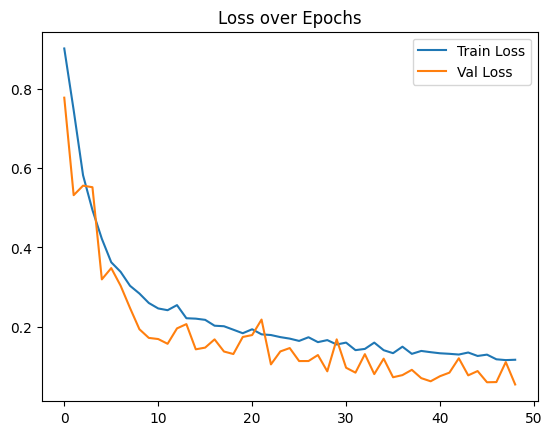

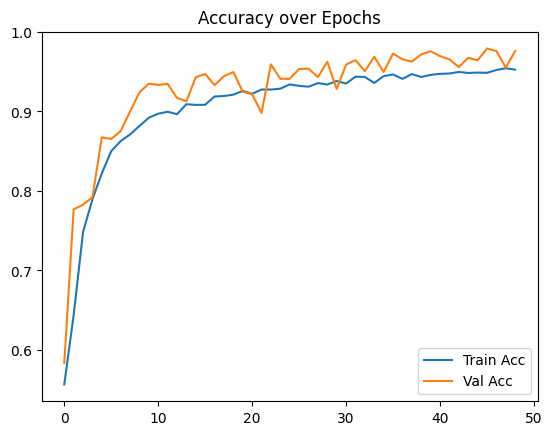

Test Evaluation: 100%|██████████| 40/40 [00:16<00:00,  2.47it/s]


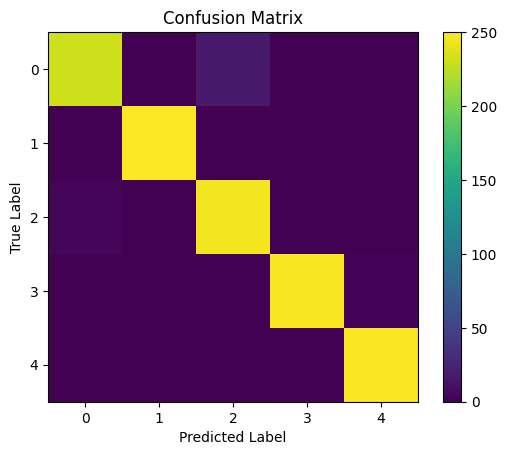

Classification Report:
              precision    recall  f1-score   support

    lung_aca       0.98      0.93      0.95       250
      lung_n       1.00      1.00      1.00       250
    lung_scc       0.93      0.98      0.96       250
   colon_aca       1.00      0.99      0.99       250
     colon_n       0.99      1.00      0.99       250

    accuracy                           0.98      1250
   macro avg       0.98      0.98      0.98      1250
weighted avg       0.98      0.98      0.98      1250

Model checkpoint saved.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import amp
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import gc  # for manual garbage collection

# … assume model, train_loader, val_loader, test_loader,
#    train_ds, val_ds, test_ds, criterion, optimizer, device, class_to_idx are defined …

# Mixed precision scaler
scaler = amp.GradScaler()

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

for epoch in range(1, 50):
    # Training
    model.train()
    running_loss = running_correct = 0

    for patches, labels in tqdm(train_loader, desc=f"Epoch {epoch} ▶ Train"):
        patches, labels = patches.to(device), labels.to(device)
        optimizer.zero_grad()

        # mixed precision forward
        with amp.autocast(device_type=device.type):
            outputs = model(patches)
            loss    = criterion(outputs, labels)

        # scaled backward & optimizer step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss    += loss.item() * labels.size(0)
        running_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = running_loss / len(train_ds)
    train_acc  = running_correct / len(train_ds)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    running_loss = running_correct = 0

    with torch.no_grad():
        for patches, labels in tqdm(val_loader, desc=f"Epoch {epoch} ▶ Val"):
            patches, labels = patches.to(device), labels.to(device)
            with amp.autocast(device_type=device.type):
                outputs = model(patches)
                loss    = criterion(outputs, labels)

            running_loss    += loss.item() * labels.size(0)
            running_correct += (outputs.argmax(1) == labels).sum().item()

    val_loss = running_loss / len(val_ds)
    val_acc  = running_correct / len(val_ds)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch} Results → "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss:   {val_loss:.4f}, Acc: {val_acc:.4f}")

    #Memory cleanup
    torch.cuda.empty_cache()
    gc.collect()

# Plot Loss & Accuracy
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses,   label="Val Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs,   label="Val Acc")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()

# Test eval
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for patches, labels in tqdm(test_loader, desc="Test Evaluation"):
        patches = patches.to(device)
        with amp.autocast(device_type=device.type):
            outputs = model(patches)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(class_to_idx.keys())))

# Save final model
state_dict = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
torch.save(state_dict, "convnext_kan_lung_colon_full.pth")
print("Model checkpoint saved.")


Predicted class index: 2, class name: lung_scc
Class probabilities: [2.2929207e-07 3.0941698e-16 9.9999976e-01 1.8922844e-11 3.9868327e-19]


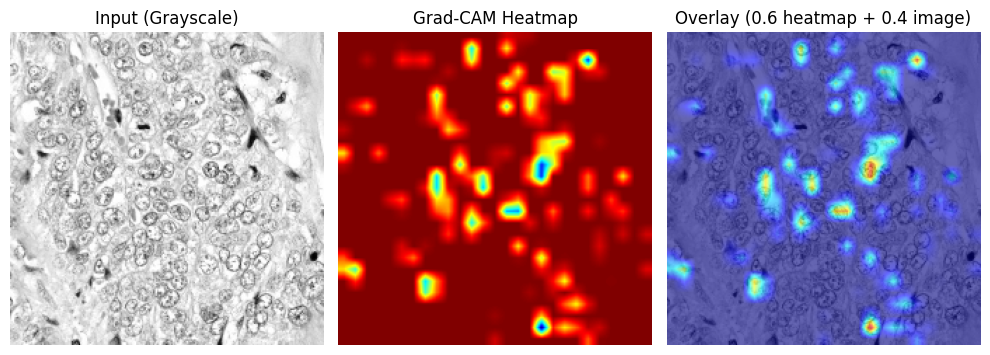

In [ ]:
import numpy as np
import os
import cv2
import math
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# --------------------------------------------------------------------------------
# (Assume ConvNeXtKAN and KANLinear have already been defined above,
#  and that `class_to_idx` and `device` are available in this scope.)
# --------------------------------------------------------------------------------

# --------------------------------------------------------------------------------
# 1. Load the saved PyTorch weights and put the model in eval mode
#    — first instantiate the base model (without DataParallel)
# --------------------------------------------------------------------------------
model_path = "/kaggle/input/convnextkan/pytorch/default/1/convnext_kan_lung_colon_full.pth"

# 1a) Instantiate the base model
base_model = ConvNeXtKAN(patch_size=56, num_classes=len(class_to_idx)).to(device)

# 1b) Load state_dict into the base model
state_dict = torch.load(model_path, map_location=device)
clean_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("module."):
        clean_state_dict[k.replace("module.", "")] = v
    else:
        clean_state_dict[k] = v
base_model.load_state_dict(clean_state_dict)

# 1c) If multiple GPUs available, wrap only for inference (but for GradCAM use base_model)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(base_model)
else:
    model = base_model

model.eval()
base_model.eval()

# --------------------------------------------------------------------------------
# 2. Preprocess a single test image into a 5D tensor [1, 1, 3, 224, 224]
# --------------------------------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),   # convert grayscale → 3 channels
    transforms.ToTensor(),                         # [3, 224, 224], values in [0,1]
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # same mean/std as training
])

img_path = (
    "/kaggle/input/lung-and-colon-cancer-histopathological-images/"
    "lung_colon_image_set/colon_image_sets/colon_aca/colonca1.jpeg"
)

pil_img = Image.open(img_path).convert("L")   # load as grayscale
tensor_img = transform(pil_img)               # [3, 224, 224]
tensor_img = tensor_img.unsqueeze(0).unsqueeze(0)  # [1, 1, 3, 224, 224]
tensor_img = tensor_img.to(device)

# --------------------------------------------------------------------------------
# 3. Forward pass to get predicted class and probabilities
# --------------------------------------------------------------------------------
with torch.no_grad():
    output = model(tensor_img)                    # shape: [1, num_classes]
    probs = F.softmax(output, dim=1).cpu().numpy()  # shape: [1, num_classes]
    pred_index = np.argmax(probs[0])

print(f"Predicted class index: {pred_index}, "
      f"class name: {list(class_to_idx.keys())[pred_index]}")
print(f"Class probabilities: {probs[0]}")

# --------------------------------------------------------------------------------
# 4. PyTorch Grad-CAM helper class (using base_model, not DataParallel-wrapped model)
# --------------------------------------------------------------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        """
        model: the unwrapped base_model (no DataParallel)
        target_layer: the nn.Module to hook (last conv layer)
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        fh = self.target_layer.register_forward_hook(forward_hook)
        bh = self.target_layer.register_backward_hook(backward_hook)
        self.hook_handles.extend([fh, bh])

    def __call__(self, input_tensor, class_idx=None):
        """
        input_tensor: [1, 1, 3, 224, 224]
        class_idx: index of the target class (if None, use top-predicted)
        """
        out = self.model(input_tensor)
        if class_idx is None:
            class_idx = out.argmax(dim=1).item()

        self.model.zero_grad()
        target_score = out[0, class_idx]
        target_score.backward(retain_graph=True)

        grads = self.gradients                  # [1, C, H', W']
        pooled_grads = grads.mean(dim=(2, 3), keepdims=True)  # [1, C, 1, 1]

        activations = self.activations          # [1, C, H', W']
        weighted = activations * pooled_grads   # [1, C, H', W']
        cam = weighted.sum(dim=1).squeeze(0)     # [H', W']

        cam = F.relu(cam)
        cam -= cam.min()
        cam /= cam.max()
        return cam.cpu().numpy()

    def close(self):
        for handle in self.hook_handles:
            handle.remove()

# --------------------------------------------------------------------------------
# 5. Generate Grad-CAM heatmap for the predicted class (using base_model)
# --------------------------------------------------------------------------------
# Last conv layer in torchvision’s convnext_tiny: features[-1][-1]
target_layer = base_model.convnext.features[-1][-1]

grad_cam = GradCAM(base_model, target_layer)
cam_map = grad_cam(tensor_img, class_idx=pred_index)  # shape: [H', W']
grad_cam.close()

# Upsample CAM to input resolution (224×224)
cam_map = cv2.resize(cam_map, (224, 224))

# Normalize heatmap to [0,255]
heatmap = np.uint8(255 * cam_map)
# Apply a slightly denser colormap (e.g. COOL instead of JET) to improve contrast
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# --------------------------------------------------------------------------------
# 6. Overlay the heatmap on the original grayscale image, using cv2.addWeighted
#    Increase alpha to make heatmap more prominent (e.g. 0.6)
# --------------------------------------------------------------------------------
orig_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
orig_gray = cv2.resize(orig_gray, (224, 224))
orig_bgr = cv2.cvtColor(orig_gray, cv2.COLOR_GRAY2BGR)

# Blend weighted: 0.4 original + 0.6 heatmap
superimposed = cv2.addWeighted(src1=heatmap, alpha=0.6,
                               src2=orig_bgr, beta=0.4, gamma=0)

# --------------------------------------------------------------------------------
# 7. Display results side by side
# --------------------------------------------------------------------------------
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.title("Input (Grayscale)")
plt.imshow(orig_gray, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlay (0.6 heatmap + 0.4 image)")
plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()


colon_aca  | Found prob = 0.004 | Pred = lung_scc (0.996)
colon_n    | Found prob = 0.000 | Pred = lung_scc (1.000)
lung_aca   | Found prob = 0.422 | Pred = lung_scc (0.578)
lung_scc   | Found prob = 0.995 | Pred = lung_scc (0.995)
lung_n     | Found prob = 0.000 | Pred = lung_aca (0.891)


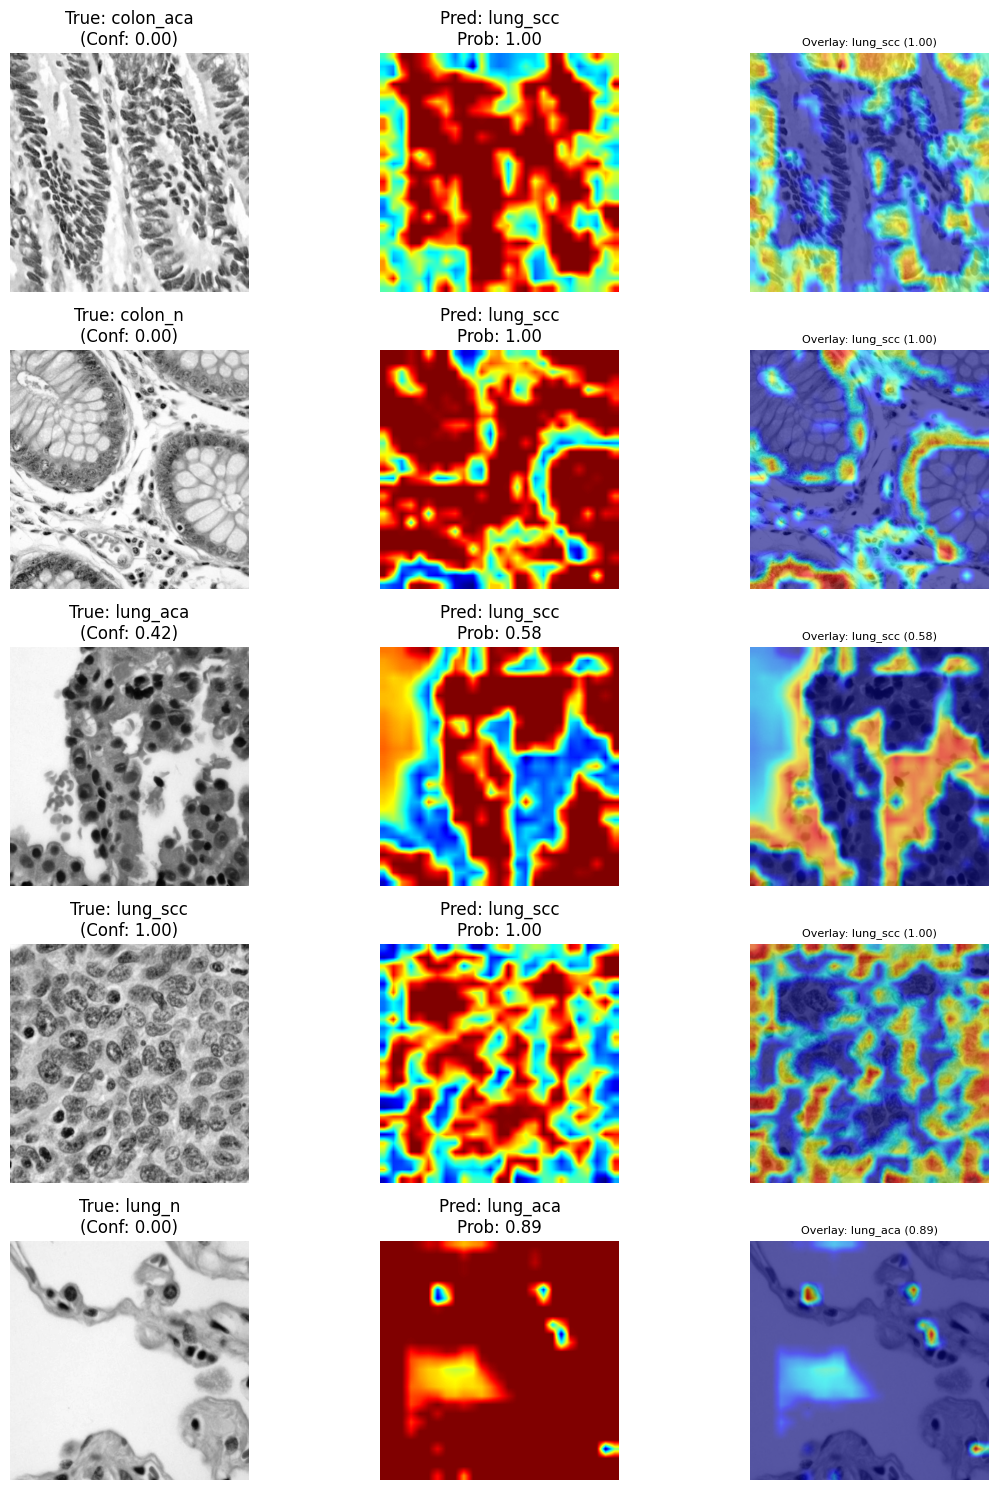

In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

# --------------------------------------------------------------------------------
# 0. Device & mapping of class names → indices
# --------------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_to_idx = {
    "lung_aca":  0,
    "lung_n":    1,
    "lung_scc":  2,
    "colon_aca": 3,
    "colon_n":   4
}

# --------------------------------------------------------------------------------
# 1. Load the trained ConvNeXtKAN model (assume ConvNeXtKAN & KANLinear are defined)
# --------------------------------------------------------------------------------
model_path = "/kaggle/input/convnextkan/pytorch/default/1/convnext_kan_lung_colon_full.pth"
base_model = ConvNeXtKAN(patch_size=56, num_classes=len(class_to_idx)).to(device)

state_dict = torch.load(model_path, map_location=device)
clean_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("module."):
        clean_state_dict[k.replace("module.", "")] = v
    else:
        clean_state_dict[k] = v

base_model.load_state_dict(clean_state_dict)
base_model.eval()

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(base_model)
else:
    model = base_model
model.eval()

# --------------------------------------------------------------------------------
# 2. Prepare transforms:
#    - we will feed a 224×224 “small” image into the model
#    - but also keep the full‐res version for overlay
# --------------------------------------------------------------------------------
transform_small = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),   # convert single‐channel → 3
    transforms.ToTensor(),                         # [3,224,224]
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

# --------------------------------------------------------------------------------
# 3. Initialize GradCAM on the last Conv2d of ConvNeXt (not on the KAN layers)
#    (assume GradCAM class is defined above)
# --------------------------------------------------------------------------------
target_layer = base_model.convnext.features[-1][-1]  # last Conv2d
grad_cam = GradCAM(base_model, target_layer)

# --------------------------------------------------------------------------------
# 4. Helper that up to “max_attempts” tries to find a high‐confidence image,
#    but returns whichever image scored highest for its true class if threshold isn’t met.
#    This is exactly the same as before, except we now store the path to the FULL image.
# --------------------------------------------------------------------------------
def find_high_confidence_image(folder_path: str,
                               class_label: str,
                               threshold: float = 0.99,
                               max_attempts: int = 100) -> (str, float):
    all_fnames = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    random.shuffle(all_fnames)

    true_idx = class_to_idx[class_label]
    best_path = None
    best_prob = -1.0
    attempts = 0

    for fname in all_fnames:
        if attempts >= max_attempts:
            break

        img_path_full = os.path.join(folder_path, fname)
        # Load full image only for overlay later; but below we create a “small” version for inference
        pil_img_full = Image.open(img_path_full).convert("L")
        # Create a resized 224×224 copy:
        pil_img_small = pil_img_full.resize((224, 224), resample=Image.BILINEAR)

        tensor_img = transform_small(pil_img_small).unsqueeze(0).unsqueeze(0).to(device)
        # shape: [1, 1, 3, 224, 224]

        with torch.no_grad():
            output = model(tensor_img)                         # [1, num_classes]
            probs  = F.softmax(output, dim=1).cpu().numpy()[0]  # [num_classes]

        prob_of_true = probs[true_idx]
        if prob_of_true > best_prob:
            best_prob = prob_of_true
            best_path = img_path_full  # store full-image path

        if best_prob >= threshold:
            break

        attempts += 1

    return best_path, best_prob

# --------------------------------------------------------------------------------
# 5. For each of the five classes, find one “high confidence” full‐resolution image
# --------------------------------------------------------------------------------
root = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set"
colon_root = os.path.join(root, "colon_image_sets")
lung_root  = os.path.join(root, "lung_image_sets")

colon_classes = [
    d for d in os.listdir(colon_root)
    if os.path.isdir(os.path.join(colon_root, d))
]
lung_classes = [
    d for d in os.listdir(lung_root)
    if os.path.isdir(os.path.join(lung_root, d))
]
all_classes = colon_classes + lung_classes  # expected: ["colon_aca","colon_n","lung_aca","lung_n","lung_scc"]

samples = []
for cls in all_classes:
    folder = os.path.join(colon_root, cls) if cls in colon_classes else os.path.join(lung_root, cls)
    best_img_path, best_prob = find_high_confidence_image(
        folder_path=folder,
        class_label=cls,
        threshold=0.99,
        max_attempts=100
    )
    samples.append((cls, best_img_path, best_prob))

assert len(samples) == 5, f"Expected 5 classes, but found {len(samples)}"

# --------------------------------------------------------------------------------
# 6. Visualize: for each of the five “best” full‐res images,
#    6a) Load the full‐res image → show in subplot
#    6b) Downsample to 224, run inference + GradCAM → get a 224×224 heatmap
#    6c) Upsample heatmap to full resolution (orig_w × orig_h)
#    6d) Overlay on full‐res grayscale and plot
# --------------------------------------------------------------------------------
plt.figure(figsize=(12, 15))

for i, (true_cls, img_path_full, conf) in enumerate(samples):
    # 6a) Open full‐resolution grayscale image
    orig = cv2.imread(img_path_full, cv2.IMREAD_GRAYSCALE)
    orig_h, orig_w = orig.shape[:2]

    # Create a 224×224 PIL for inference
    pil_img_full = Image.open(img_path_full).convert("L")
    pil_img_small = pil_img_full.resize((224, 224), resample=Image.BILINEAR)
    tensor_img = transform_small(pil_img_small).unsqueeze(0).unsqueeze(0).to(device)
    # → [1, 1, 3, 224, 224]

    # 6b) Forward pass → softmax + top‐pred
    with torch.no_grad():
        output   = model(tensor_img)                       # [1, num_classes]
        probs    = F.softmax(output, dim=1).cpu().numpy()[0]  # [num_classes]
        pred_idx = np.argmax(probs)
        pred_cls = list(class_to_idx.keys())[pred_idx]
        pred_prob = probs[pred_idx]

    print(f"{true_cls:<10s} | Found prob = {conf:.3f} | Pred = {pred_cls} ({pred_prob:.3f})")

    # 6c) Compute GradCAM heatmap at 224×224 for predicted class
    cam_map = grad_cam(tensor_img, class_idx=pred_idx)  # [H', W'] e.g. [7,7] or [14,14]
    cam_map = cv2.resize(cam_map, (224, 224))           # upsample to 224×224
    heatmap_small = np.uint8(255 * cam_map)
    heatmap_small = cv2.applyColorMap(heatmap_small, cv2.COLORMAP_JET)

    # 6d) Upsample the 224×224 heatmap to full‐res (orig_w × orig_h)
    heatmap_full = cv2.resize(heatmap_small, (orig_w, orig_h))

    # 6e) Overlay on the full‐res grayscale
    orig_bgr = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)
    overlay_full = cv2.addWeighted(src1=heatmap_full, alpha=0.6, src2=orig_bgr, beta=0.4, gamma=0)

    # 6f) Plot the results in a 5×3 grid: [full_orig | small_heatmap | full_overlay]
    row = i

    # — Full original (grayscale)
    plt.subplot(5, 3, row*3 + 1)
    plt.imshow(orig, cmap="gray")
    plt.title(f"True: {true_cls}\n(Conf: {conf:.2f})")
    plt.axis("off")

    # — Small heatmap at 224×224 (for reference)
    plt.subplot(5, 3, row*3 + 2)
    plt.imshow(heatmap_small)
    plt.title(f"Pred: {pred_cls}\nProb: {pred_prob:.2f}")
    plt.axis("off")

    # — Full‐res overlay
    plt.subplot(5, 3, row*3 + 3)
    plt.imshow(cv2.cvtColor(overlay_full, cv2.COLOR_BGR2RGB))
    plt.title(f"Overlay: {pred_cls} ({pred_prob:.2f})", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------------
# 7. Cleanup GradCAM hooks
# --------------------------------------------------------------------------------
grad_cam.close()


Full image path = /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca2506.jpeg
    True = lung_aca, Slide‐level Pred = lung_scc, Prob = 0.997

Full image path = /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n/lungn629.jpeg
    True = lung_n, Slide‐level Pred = lung_scc, Prob = 0.859

Full image path = /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc/lungscc4985.jpeg
    True = lung_scc, Slide‐level Pred = lung_scc, Prob = 0.922

Full image path = /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca3658.jpeg
    True = colon_aca, Slide‐level Pred = lung_scc, Prob = 0.995

Full image path = /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_n/colonn3211.jpeg
    True = colon_n, Slide‐level Pred = 

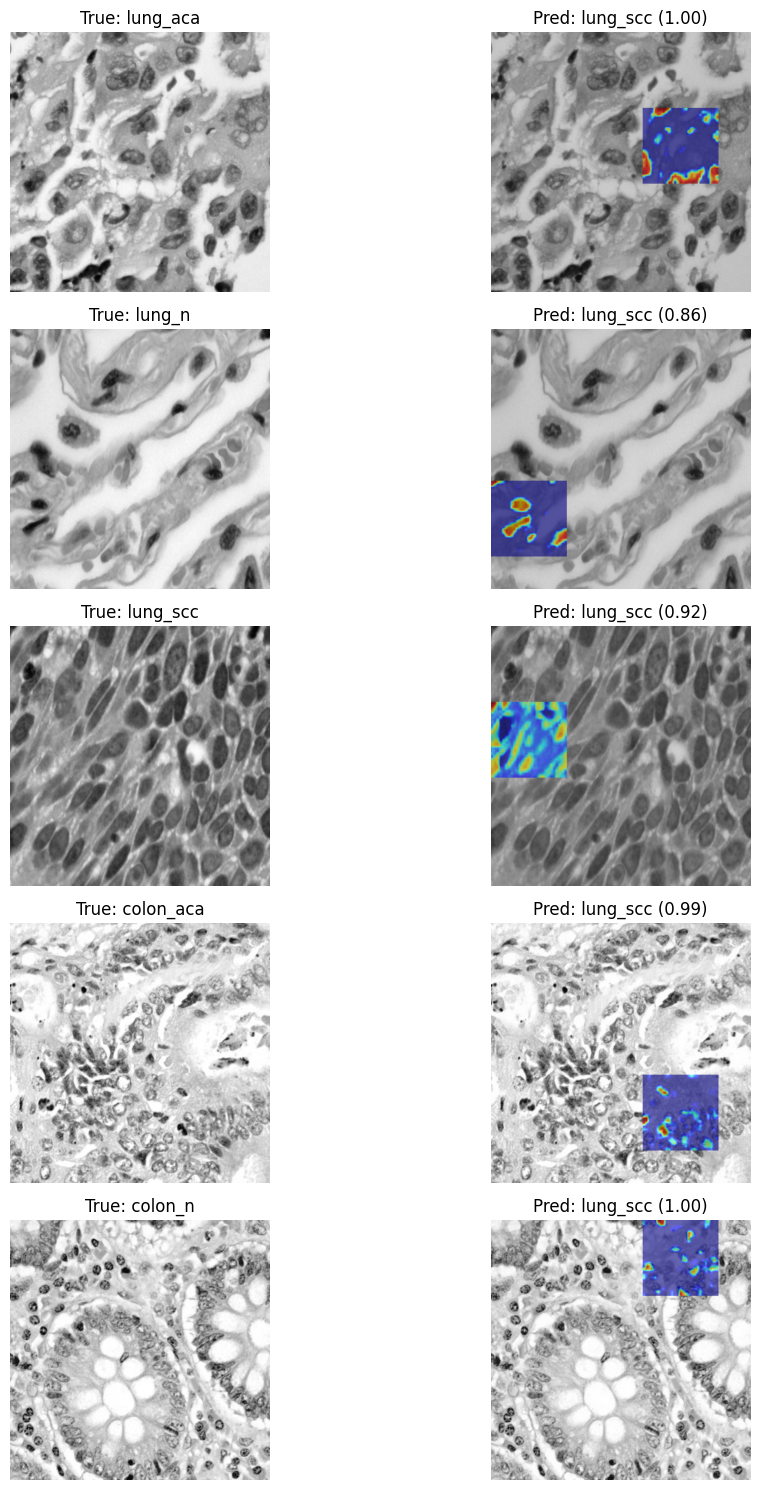

In [ ]:
import os
import random
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_to_idx = {
    "lung_aca":  0,
    "lung_n":    1,
    "lung_scc":  2,
    "colon_aca": 3,
    "colon_n":   4
}

model_path = "/kaggle/input/convnextkan/pytorch/default/1/convnext_kan_lung_colon_full.pth"
base_model = ConvNeXtKAN(patch_size=56, num_classes=len(class_to_idx)).to(device)

state_dict = torch.load(model_path, map_location=device)
clean_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("module."):
        clean_state_dict[k.replace("module.", "")] = v
    else:
        clean_state_dict[k] = v

base_model.load_state_dict(clean_state_dict)
base_model.eval()

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(base_model)
else:
    model = base_model
model.eval()

# transform used for inference on 224×224 tiles
transform_small = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),   # convert single‐channel → 3 channels
    transforms.ToTensor(),                         # [3, 224, 224], values in [0,1]
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])
# NOTE: we will skip `Resize((224,224))` here, because we will manually crop 224×224 tiles
#       from the full image.  Each tile is already exactly 224×224.


# Initialize GradCAM on the last Conv2d layer of ConvNeXt
target_layer = base_model.convnext.features[-1][-1]  # last Conv2d in convnext_tiny
grad_cam = GradCAM(base_model, target_layer)


# 4. Utility: slide‐level inference by tiling
def slide_predict_and_cam(full_img_path: str,
                          tile_size: int = 224,
                          stride: int = 224) -> (
                              str,      # predicted_class_name
                              float,    # predicted_class_prob (slide‐level)
                              np.ndarray,# full‐res heatmap overlay (H,W,3)
                              np.ndarray # full‐res original grayscale (H,W)
                          ):
    """
    1. Load the full grayscale image from disk.
    2. Divide it into non‐overlapping (tile_size × tile_size) patches.
    3. Run ConvNeXtKAN on each tile → get tile‐level softmax scores.
    4. Average tile‐level probabilities across all tiles to produce a slide‐level probability vector.
    5. The slide‐level predicted class = argmax(aggregated_probs).
    6. Among all tiles, pick the tile whose softmax(predicted_class) is largest.
       a. Run Grad‐CAM on that tile to get a 224×224 heatmap.
       b. Upsample that 224×224 heatmap back to the tile's location in the full‐res image.
    7. Return: (predicted_class_name, predicted_class_prob, full_overlay, full_grayscale).
    """

    # Load the full image in grayscale
    orig = cv2.imread(full_img_path, cv2.IMREAD_GRAYSCALE)
    if orig is None:
        raise FileNotFoundError(f"Could not load {full_img_path}")
    orig_h, orig_w = orig.shape[:2]

    # Compute how many tiles fit in height & width (floor division)
    n_tiles_h = orig_h // tile_size
    n_tiles_w = orig_w // tile_size

    if n_tiles_h == 0 or n_tiles_w == 0:
        raise ValueError(f"Image {full_img_path} is smaller than {tile_size} in at least one dimension")

    # We will collect tile‐level probabilities into a list
    tile_probs = []       # list of shape [num_tiles, num_classes]
    tile_coords = []      # list of (y0, x0) for each tile
    tile_images = []      # store the actual 224×224 crop as a PIL/NumPy array

    # 4c) Loop over non‐overlapping 224×224 patches
    for i in range(n_tiles_h):
        y0 = i * tile_size
        for j in range(n_tiles_w):
            x0 = j * tile_size

            crop = orig[y0:y0+tile_size, x0:x0+tile_size]  # [224,224]
            # Convert to PIL and then to tensor
            pil_crop = Image.fromarray(crop).convert("L")  # grayscale PIL
            tensor_crop = transform_small(pil_crop).unsqueeze(0).unsqueeze(0).to(device)
            # → shape [1,1,3,224,224]

            with torch.no_grad():
                output = model(tensor_crop)                       # [1, num_classes]
                probs  = F.softmax(output, dim=1).cpu().numpy()[0]  # [num_classes]

            tile_probs.append(probs)
            tile_coords.append((y0, x0))
            tile_images.append(tensor_crop)  # we keep tensor so we can do Grad‐CAM later

    tile_probs = np.stack(tile_probs, axis=0)  # shape [n_tiles, num_classes]
    # 4d) Aggregate via mean
    slide_probs = tile_probs.mean(axis=0)      # [num_classes]
    pred_idx    = slide_probs.argmax()         # scalar
    pred_name   = list(class_to_idx.keys())[pred_idx]
    pred_prob   = float(slide_probs[pred_idx]) # python float

    # 4e) Find the tile with the highest softmax for that predicted class
    best_tile_idx = int(np.argmax(tile_probs[:, pred_idx]))
    best_y0, best_x0 = tile_coords[best_tile_idx]
    best_patch_tensor = tile_images[best_tile_idx]  # shape [1,1,3,224,224]

    # 4f) Compute Grad‐CAM heatmap on that tile
    cam_map = grad_cam(best_patch_tensor, class_idx=pred_idx)  # [H′, W′], typically [7,7] or [14,14]
    cam_map = cv2.resize(cam_map, (tile_size, tile_size))      # upsample to 224×224
    heatmap_tile = np.uint8(255 * cam_map)
    heatmap_tile = cv2.applyColorMap(heatmap_tile, cv2.COLORMAP_JET)  # [224,224,3]

    # 4g) Create a full‐res overlay copy
    #    Start with full grayscale → convert to BGR
    orig_bgr = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)  # [H,W,3]
    overlay_full = orig_bgr.copy()

    # 4h) Paste the heatmap_tile into overlay_full at (best_x0, best_y0)
    overlay_full[best_y0:best_y0+tile_size, best_x0:best_x0+tile_size] = \
        cv2.addWeighted(
            src1=heatmap_tile,
            alpha=0.6,
            src2=orig_bgr[best_y0:best_y0+tile_size, best_x0:best_x0+tile_size],
            beta=0.4,
            gamma=0
        )

    return pred_name, pred_prob, overlay_full, orig


# --------------------------------------------------------------------------------
# 5. Let’s pick one “full image” from each class (using the same “find high‐confidence image” helper),
#    and then run slide_predict_and_cam() on it. You’ll see all five classes represented.
# --------------------------------------------------------------------------------
def find_any_one_image_per_class(colon_root, lung_root):
    """
    Returns a list of (class_name, full_image_path).
    We just pick a random image from each class folder.
    (You could re‐use the high‐confidence finder here, but random is simpler to demo.)
    """
    result = []
    for cls in list(class_to_idx.keys()):
        if cls.startswith("colon_"):
            folder = os.path.join(colon_root, cls)
        else:
            folder = os.path.join(lung_root, cls)
        imgs = [f for f in os.listdir(folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        if not imgs:
            continue
        chosen = random.choice(imgs)
        result.append((cls, os.path.join(folder, chosen)))
    return result

root = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set"
colon_root = os.path.join(root, "colon_image_sets")
lung_root  = os.path.join(root, "lung_image_sets")

# Pick exactly one random image per class
samples = find_any_one_image_per_class(colon_root, lung_root)
assert len(samples) == 5

# --------------------------------------------------------------------------------
# 6. For each sampled (class, path), do slide_predict_and_cam and plot
# --------------------------------------------------------------------------------
plt.figure(figsize=(12, 15))

for i, (true_cls, full_path) in enumerate(samples):
    pred_cls, pred_prob, overlay_full, orig_full = slide_predict_and_cam(full_path)

    print(
        f"Full image path = {full_path}\n"
        f"    True = {true_cls}, Slide‐level Pred = {pred_cls}, Prob = {pred_prob:.3f}\n"
    )

    # Plot: 5×2 grid to show the full original + the overlay
    row = i
    # 6a) Original full image (grayscale)
    plt.subplot(5, 2, row*2 + 1)
    plt.imshow(orig_full, cmap="gray")
    plt.title(f"True: {true_cls}")
    plt.axis("off")

    # 6b) Overlay full image with GradCAM patch
    plt.subplot(5, 2, row*2 + 2)
    plt.imshow(cv2.cvtColor(overlay_full, cv2.COLOR_BGR2RGB))
    plt.title(f"Pred: {pred_cls} ({pred_prob:.2f})")
    plt.axis("off")

plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------------
# 7. Cleanup GradCAM hooks
# --------------------------------------------------------------------------------
grad_cam.close()
